In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


In [2]:
import pandas as pd

# File path in the Kaggle environment
file_path = '/kaggle/input/sampled-dns-specifiedlabels/stratified_sampled_datase55t.csv'

# Reading the CSV file
data = pd.read_csv(file_path)

# Display the first few rows of the data
print(data.head())

   Unnamed: 0                                            flow_id  \
0       75721  2019-08-20 15:02:36.092264_150.150.150.10_5807...   
1       80184  2019-08-20 15:24:57.104881_150.150.150.10_5807...   
2       19864  2019-08-20 09:59:19.017606_150.150.150.10_5807...   
3       76699  2019-08-20 15:08:43.299405_150.150.150.10_5807...   
4       92991  2019-08-20 16:49:07.213847_150.150.150.10_5807...   

                    timestamp          src_ip  src_port   dst_ip  dst_port  \
0  2019-08-20 15:02:36.092264  150.150.150.10     58075  8.8.8.8        53   
1  2019-08-20 15:24:57.104881  150.150.150.10     58075  8.8.8.8        53   
2  2019-08-20 09:59:19.017606  150.150.150.10     58075  8.8.8.8        53   
3  2019-08-20 15:08:43.299405  150.150.150.10     58075  8.8.8.8        53   
4  2019-08-20 16:49:07.213847  150.150.150.10     58075  8.8.8.8        53   

  protocol  duration  packets_numbers  ...  distinct_A_records  \
0      DNS  0.128087                2  ...              

In [3]:
from tabulate import tabulate

# Summary information
general_info = [
    ["Number of Rows", data.shape[0]],
    ["Number of Columns", data.shape[1]],
    ["Total Missing Values", data.isnull().sum().sum()]
]

# Tabulate and display
table = tabulate(general_info, headers=["Metric", "Value"], tablefmt="pretty")
print(table)


+----------------------+-------+
|        Metric        | Value |
+----------------------+-------+
|    Number of Rows    | 9998  |
|  Number of Columns   |  122  |
| Total Missing Values | 9714  |
+----------------------+-------+


In [4]:
for column, dtype in data.dtypes.items():
    print(f"Column: {column}, Type: {dtype}")

Column: Unnamed: 0, Type: int64
Column: flow_id, Type: object
Column: timestamp, Type: object
Column: src_ip, Type: object
Column: src_port, Type: int64
Column: dst_ip, Type: object
Column: dst_port, Type: int64
Column: protocol, Type: object
Column: duration, Type: float64
Column: packets_numbers, Type: int64
Column: receiving_packets_numbers, Type: int64
Column: sending_packets_numbers, Type: int64
Column: handshake_duration, Type: object
Column: delta_start, Type: object
Column: total_bytes, Type: int64
Column: receiving_bytes, Type: int64
Column: sending_bytes, Type: int64
Column: packets_rate, Type: float64
Column: receiving_packets_rate, Type: float64
Column: sending_packets_rate, Type: float64
Column: packets_len_rate, Type: float64
Column: receiving_packets_len_rate, Type: float64
Column: sending_packets_len_rate, Type: float64
Column: min_packets_len, Type: int64
Column: max_packets_len, Type: int64
Column: mean_packets_len, Type: float64
Column: median_packets_len, Type: floa

In [5]:
label_counts = data['label'].value_counts().reset_index()

# Rename columns for better readability
label_counts.columns = ['Label', 'Count']

# Calculate the percentage distribution
label_counts['Percentage'] = (label_counts['Count'] / label_counts['Count'].sum()) * 100

# Print the result
print(label_counts)

      Label  Count  Percentage
0    Benign   9567   95.689138
1   Malware    227    2.270454
2  Phishing    120    1.200240
3      Spam     84    0.840168


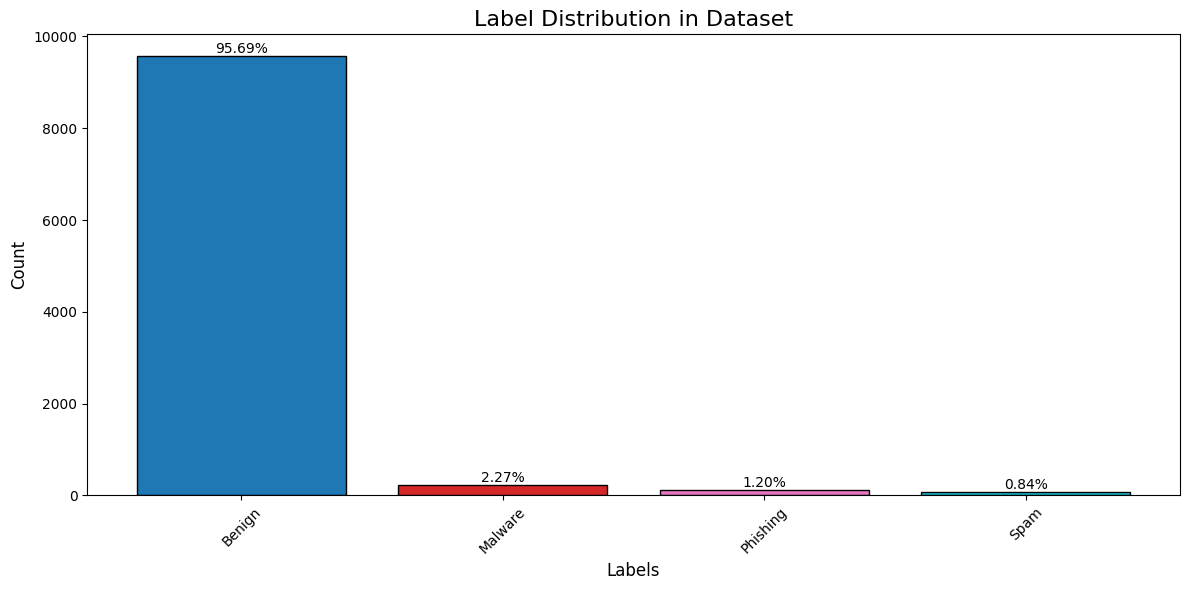

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming label_counts contains the label distribution
label_counts = data['label'].value_counts()

# Generate colors for each bar
colors = plt.cm.tab10(np.linspace(0, 1, len(label_counts)))

# Calculate percentages
percentages = (label_counts / label_counts.sum()) * 100

# Create the bar plot
plt.figure(figsize=(12, 6))
bars = plt.bar(label_counts.index, label_counts.values, color=colors, edgecolor='black')

# Add percentages above the bars
for bar, percentage in zip(bars, percentages):
    height = bar.get_height()
    # Add the percentage above the bar
    plt.text(bar.get_x() + bar.get_width() / 2, height + 2, f'{percentage:.2f}%', 
             ha='center', va='bottom', fontsize=10, color='black')

# Customize the plot
plt.title('Label Distribution in Dataset', fontsize=16)
plt.xlabel('Labels', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)

# Display the plot
plt.tight_layout()
plt.show()


In [5]:
missing_data = data.isna().sum()
for column, missing_count in missing_data.items():
    if missing_count > 0:
        print(f"Column: {column}, Missing Values: {missing_count}")

Column: coefficient_of_variation_receiving_packets_delta_len, Missing Values: 7
Column: coefficient_of_variation_sending_packets_delta_len, Missing Values: 7
Column: dns_subdomain_name_length, Missing Values: 9694
Column: ttl_values_coefficient_of_variation, Missing Values: 6


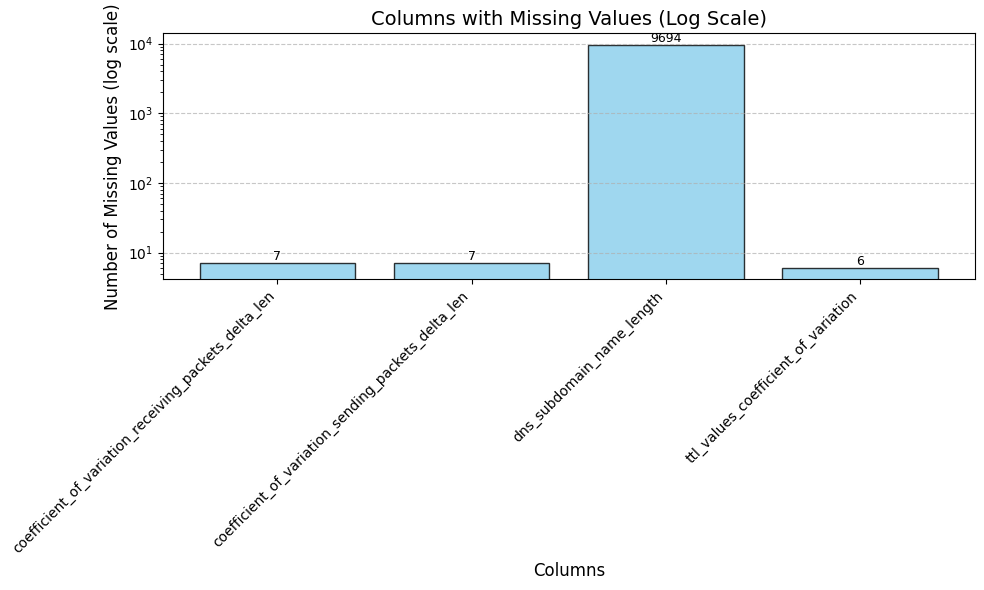

In [8]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


missing_values = data.isnull().sum()

# Filter columns with missing values
columns_with_missing = missing_values[missing_values > 0]

# Plot the missing values with a logarithmic scale
plt.figure(figsize=(10, 6))
plt.bar(columns_with_missing.index, columns_with_missing.values, color='skyblue', edgecolor='black', alpha=0.8)
plt.yscale('log')  # Apply logarithmic scale to the y-axis
plt.title('Columns with Missing Values (Log Scale)', fontsize=14)
plt.xlabel('Columns', fontsize=12)
plt.ylabel('Number of Missing Values (log scale)', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate each bar with the exact value
for index, value in enumerate(columns_with_missing.values):
    plt.text(index, value, str(value), ha='center', va='bottom', fontsize=9)

# Show the plot
plt.show()



# Filtered Data

In [4]:
# Filter the dataset to exclude 'Malware' and 'Spam'
filtered_data = data[~data['label'].isin(['Malware', 'Spam'])]

# Check the updated counts of the labels
print(filtered_data['label'].value_counts())


label
Benign      9567
Phishing     120
Name: count, dtype: int64


In [7]:
general_info = [
    ["Number of Rows", filtered_data.shape[0]],
    ["Number of Columns", filtered_data.shape[1]],
    ["Total Missing Values", filtered_data.isnull().sum().sum()]
]

# Tabulate and display
table = tabulate(general_info, headers=["Metric", "Value"], tablefmt="pretty")
print(table)

+----------------------+-------+
|        Metric        | Value |
+----------------------+-------+
|    Number of Rows    | 9687  |
|  Number of Columns   |  122  |
| Total Missing Values | 9419  |
+----------------------+-------+


In [11]:
label_counts = filtered_data['label'].value_counts().reset_index()

# Rename columns for better readability
label_counts.columns = ['Label', 'Count']

# Calculate the percentage distribution
label_counts['Percentage'] = (label_counts['Count'] / label_counts['Count'].sum()) * 100

# Print the result
print(label_counts)

      Label  Count  Percentage
0    Benign   9567   98.761226
1  Phishing    120    1.238774


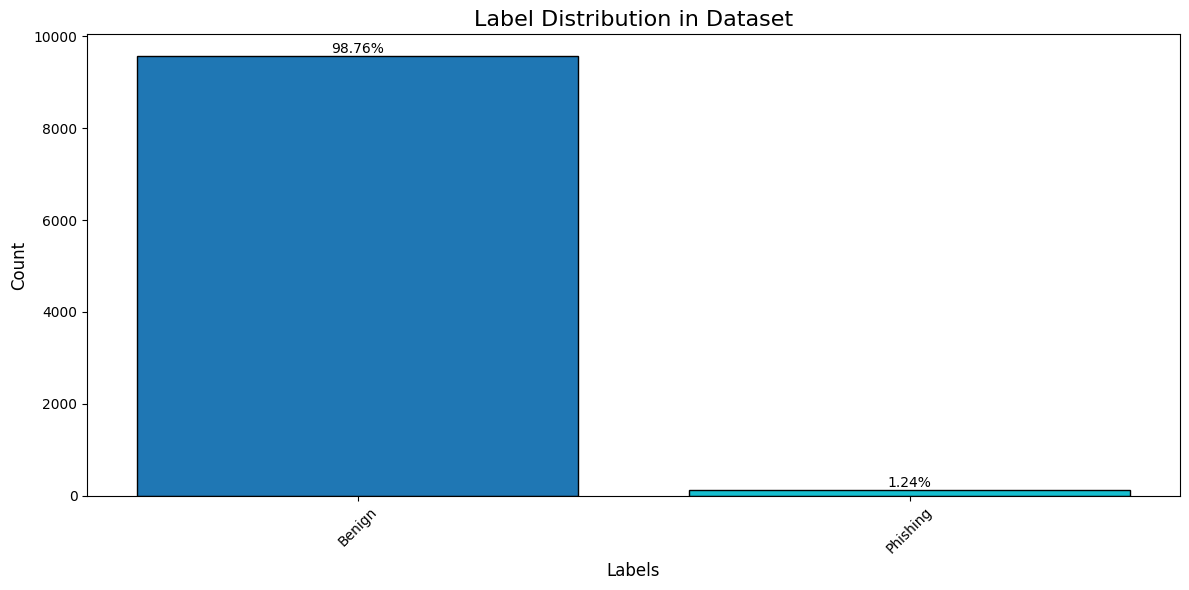

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming label_counts contains the label distribution
label_counts = filtered_data['label'].value_counts()

# Generate colors for each bar
colors = plt.cm.tab10(np.linspace(0, 1, len(label_counts)))

# Calculate percentages
percentages = (label_counts / label_counts.sum()) * 100

# Create the bar plot
plt.figure(figsize=(12, 6))
bars = plt.bar(label_counts.index, label_counts.values, color=colors, edgecolor='black')

# Add percentages above the bars
for bar, percentage in zip(bars, percentages):
    height = bar.get_height()
    # Add the percentage above the bar
    plt.text(bar.get_x() + bar.get_width() / 2, height + 2, f'{percentage:.2f}%', 
             ha='center', va='bottom', fontsize=10, color='black')

# Customize the plot
plt.title('Label Distribution in Dataset', fontsize=16)
plt.xlabel('Labels', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)

# Display the plot
plt.tight_layout()
plt.show()


# EDA before PreProcessing

In [13]:
print("\nSummary Statistics:")
print(filtered_data.describe())


Summary Statistics:
         Unnamed: 0      src_port  dst_port     duration  packets_numbers  \
count   9687.000000   9687.000000    9687.0  9687.000000      9687.000000   
mean   49315.876329  57927.610715      53.0     0.137966         2.003716   
std    28906.810666   1316.090009       0.0     0.719878         0.086137   
min       23.000000  46177.000000      53.0     0.024916         2.000000   
25%    24095.500000  58075.000000      53.0     0.034266         2.000000   
50%    48655.000000  58075.000000      53.0     0.044268         2.000000   
75%    74432.000000  58075.000000      53.0     0.113389         2.000000   
max    99993.000000  58075.000000      53.0    29.539999         4.000000   

       receiving_packets_numbers  sending_packets_numbers  total_bytes  \
count                9687.000000              9687.000000  9687.000000   
mean                    1.001858                 1.001858   204.070197   
std                     0.043069                 0.043069    42

In [14]:
for i, col in enumerate(filtered_data.columns, 1):
    print(f"{i}: {col}")


1: Unnamed: 0
2: flow_id
3: timestamp
4: src_ip
5: src_port
6: dst_ip
7: dst_port
8: protocol
9: duration
10: packets_numbers
11: receiving_packets_numbers
12: sending_packets_numbers
13: handshake_duration
14: delta_start
15: total_bytes
16: receiving_bytes
17: sending_bytes
18: packets_rate
19: receiving_packets_rate
20: sending_packets_rate
21: packets_len_rate
22: receiving_packets_len_rate
23: sending_packets_len_rate
24: min_packets_len
25: max_packets_len
26: mean_packets_len
27: median_packets_len
28: mode_packets_len
29: standard_deviation_packets_len
30: variance_packets_len
31: coefficient_of_variation_packets_len
32: skewness_packets_len
33: min_receiving_packets_len
34: max_receiving_packets_len
35: mean_receiving_packets_len
36: median_receiving_packets_len
37: mode_receiving_packets_len
38: standard_deviation_receiving_packets_len
39: variance_receiving_packets_len
40: coefficient_of_variation_receiving_packets_len
41: skewness_receiving_packets_len
42: min_sending_packe

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

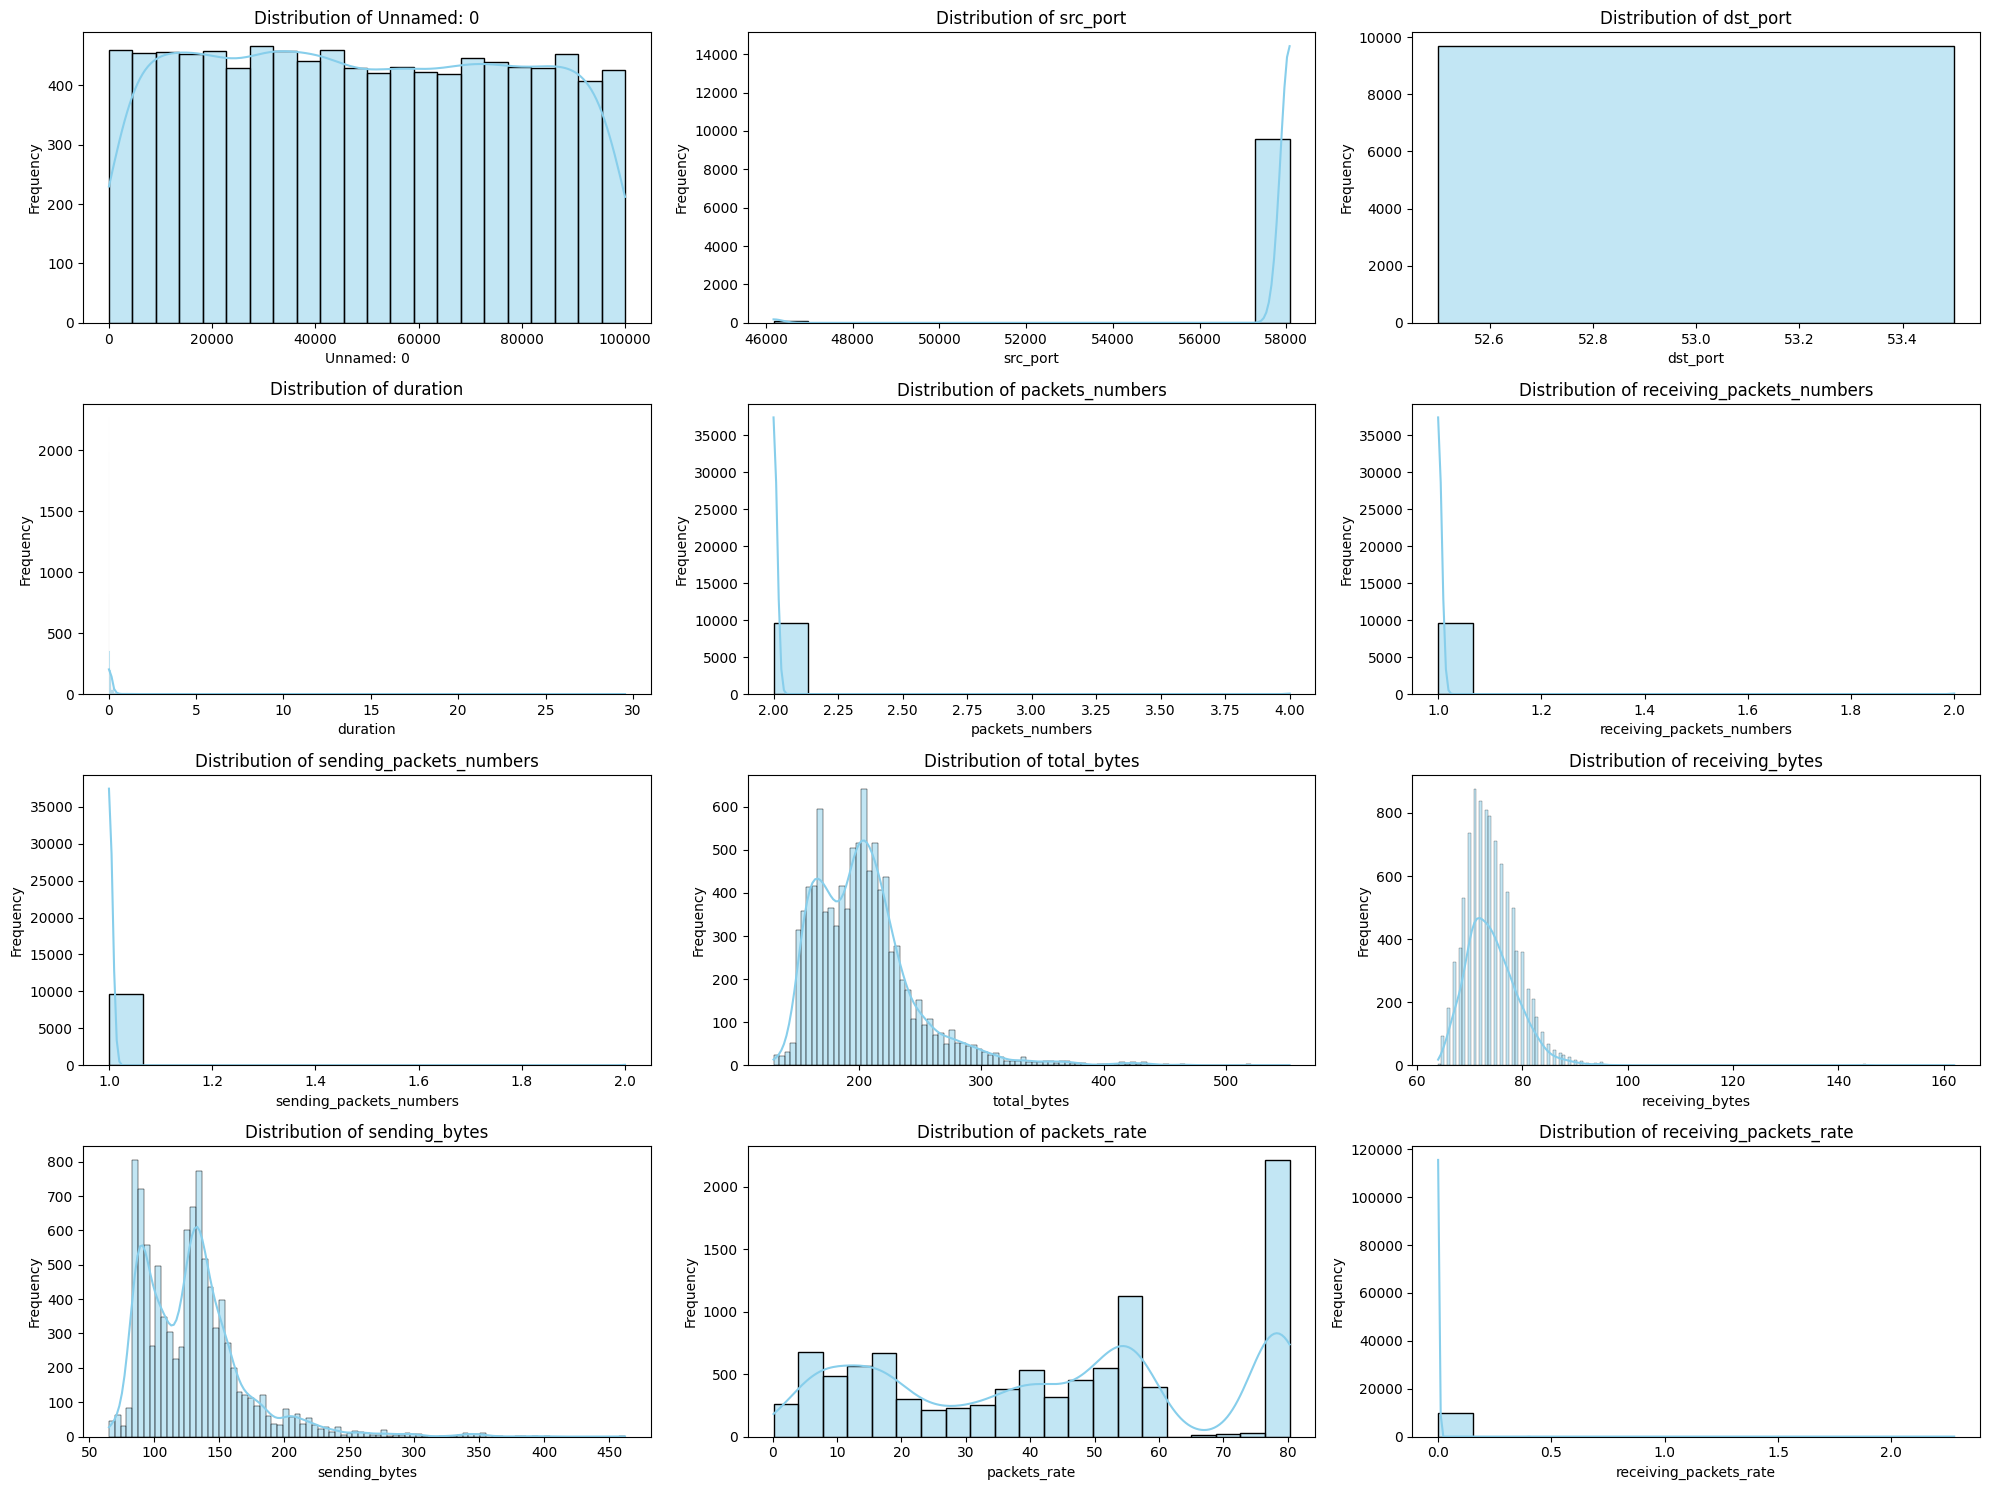

In [17]:
# Checking data distribution for numerical columns
numerical_cols = filtered_data.select_dtypes(include=['float64', 'int64']).columns
numerical_cols

plt.figure(figsize=(20, 15))
for i, col in enumerate(numerical_cols[:12], 1):  # Display up to 12 columns at a time
    plt.subplot(4, 3, i)
    sns.histplot(filtered_data[col].dropna(), kde=True, color='skyblue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

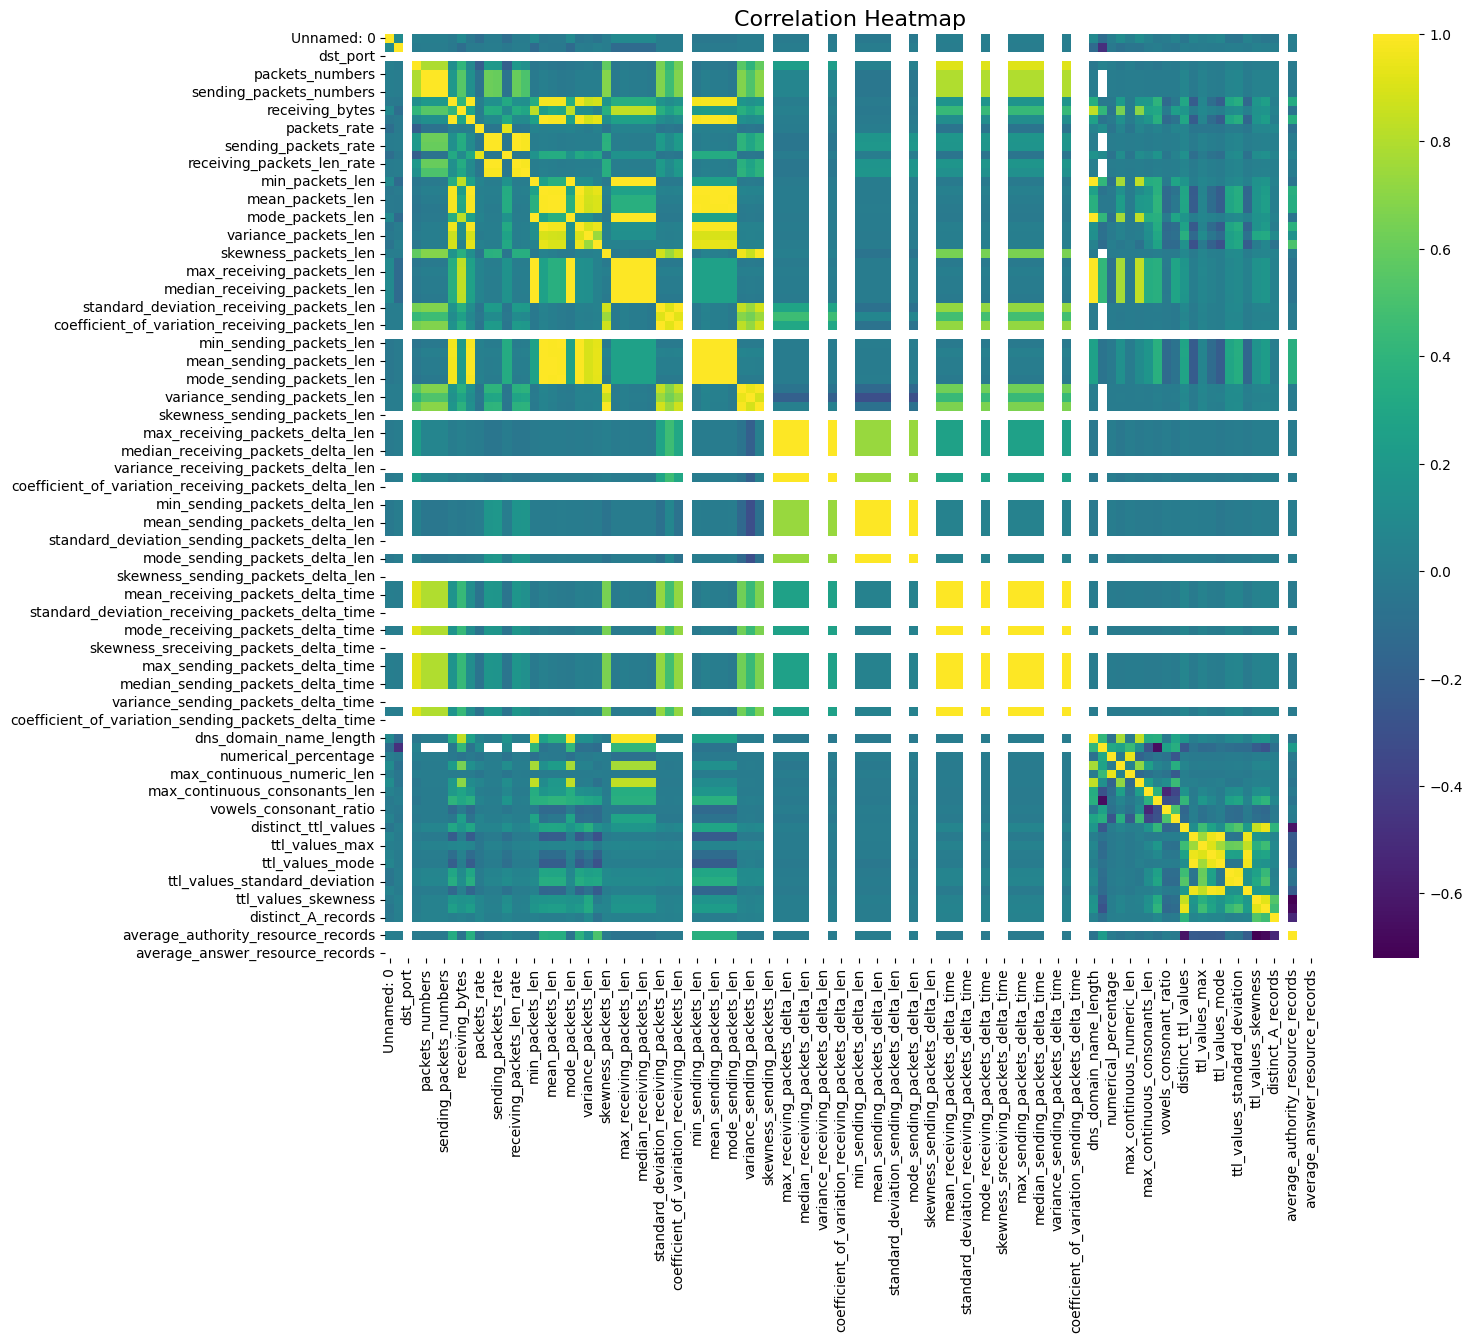

In [18]:
# Correlation Heatmap
plt.figure(figsize=(15, 12))
correlation_matrix = filtered_data[numerical_cols].corr()
sns.heatmap(correlation_matrix, annot=False, cmap='viridis')
plt.title('Correlation Heatmap', fontsize=16)
plt.show()

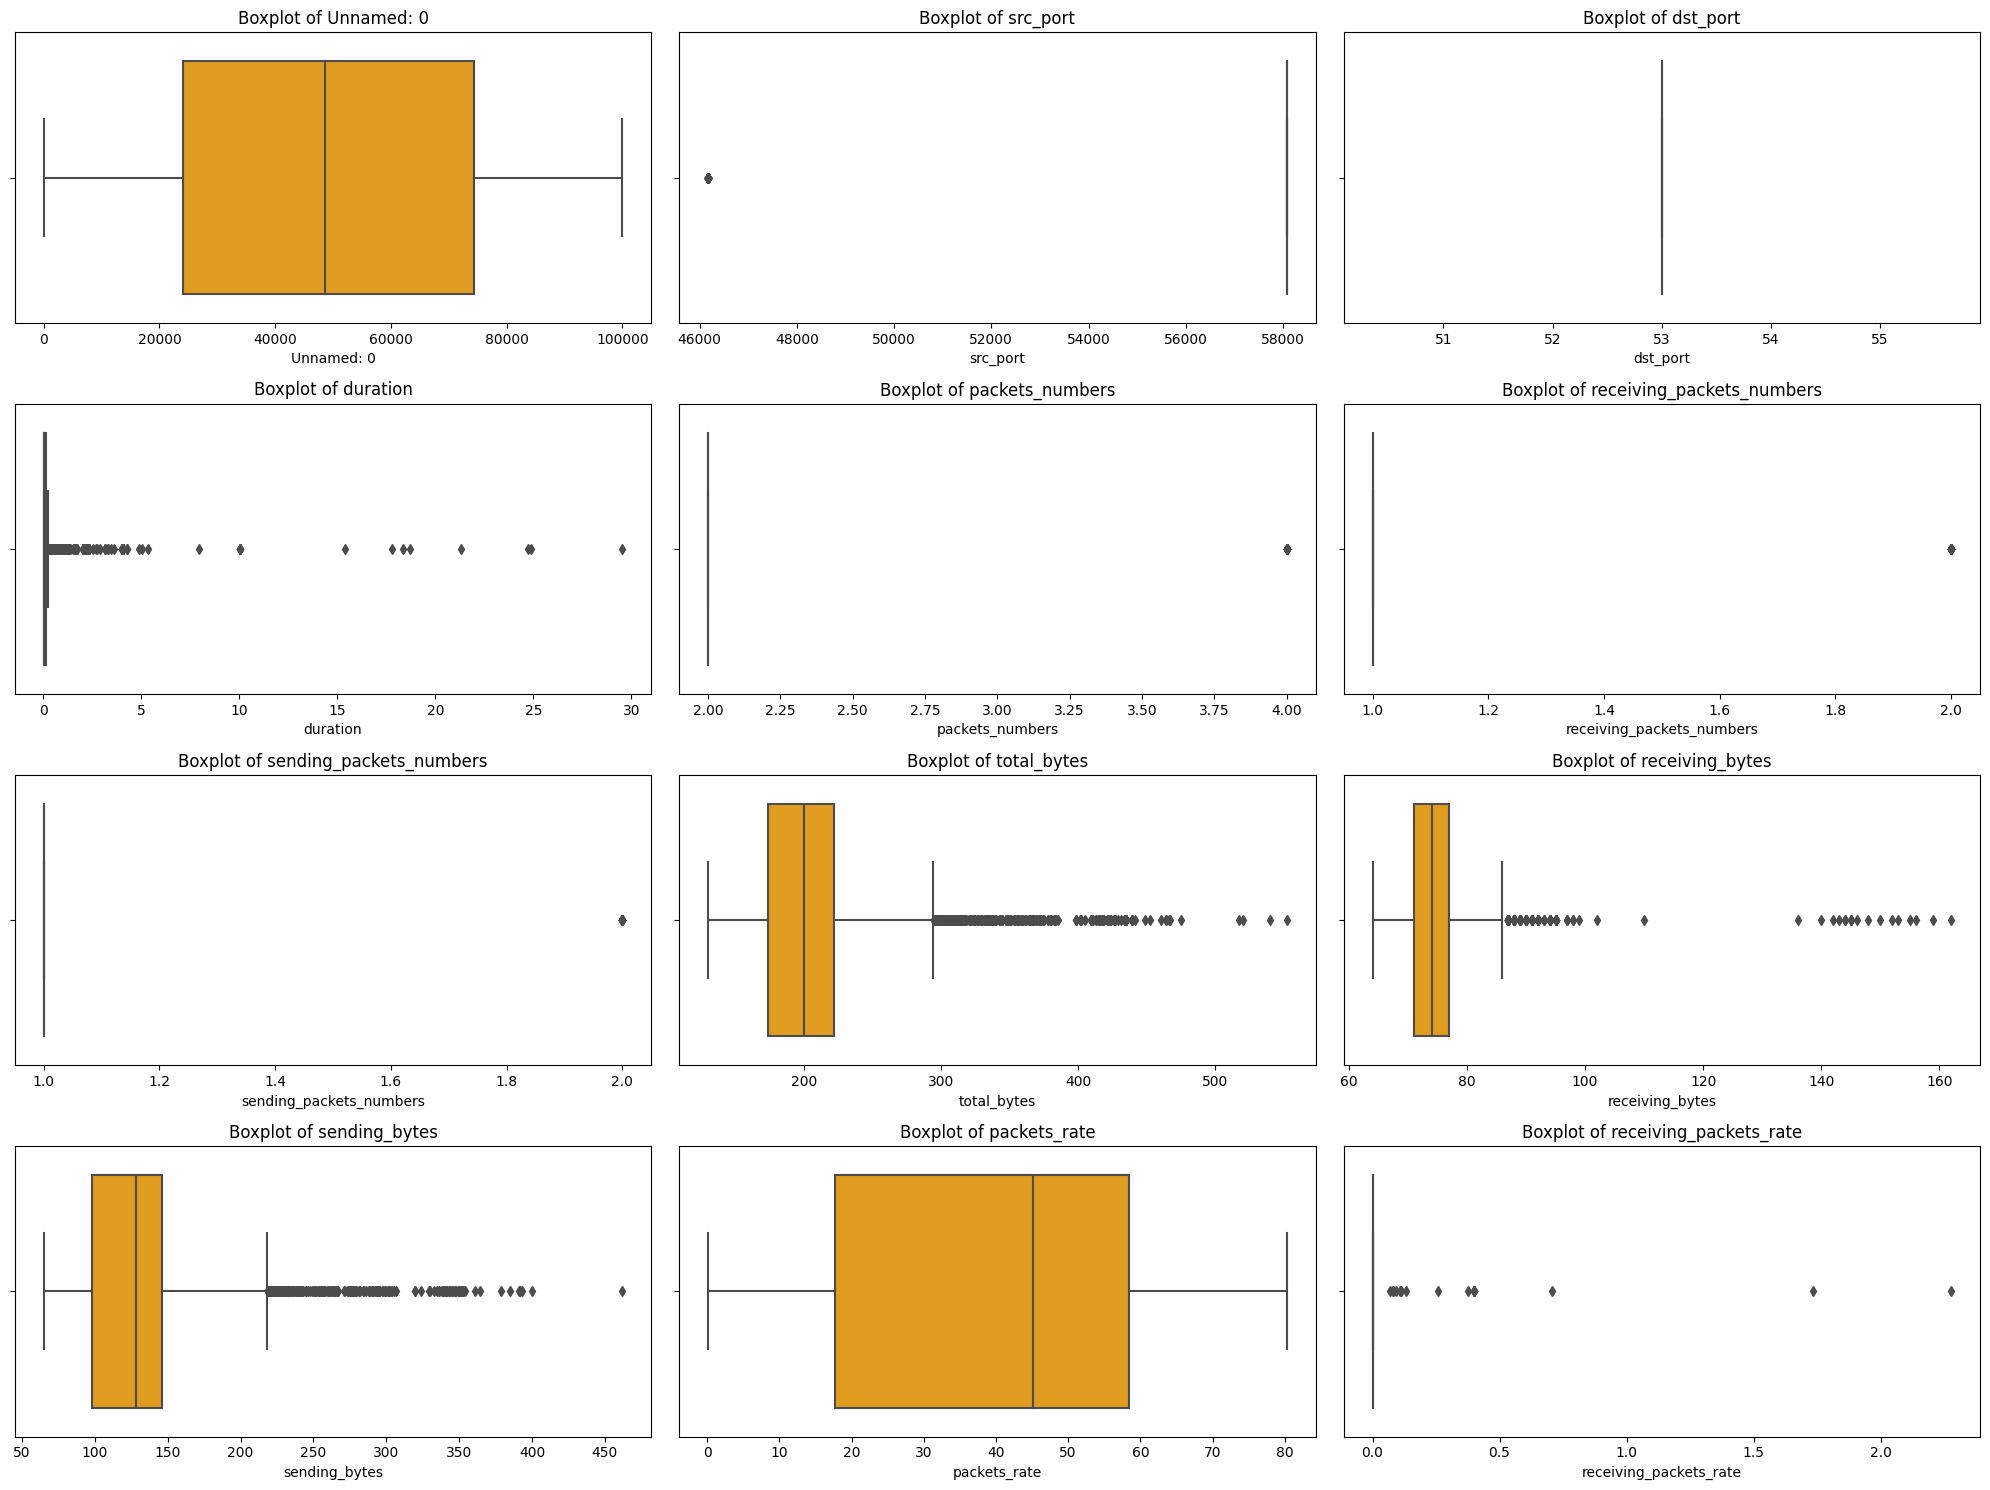

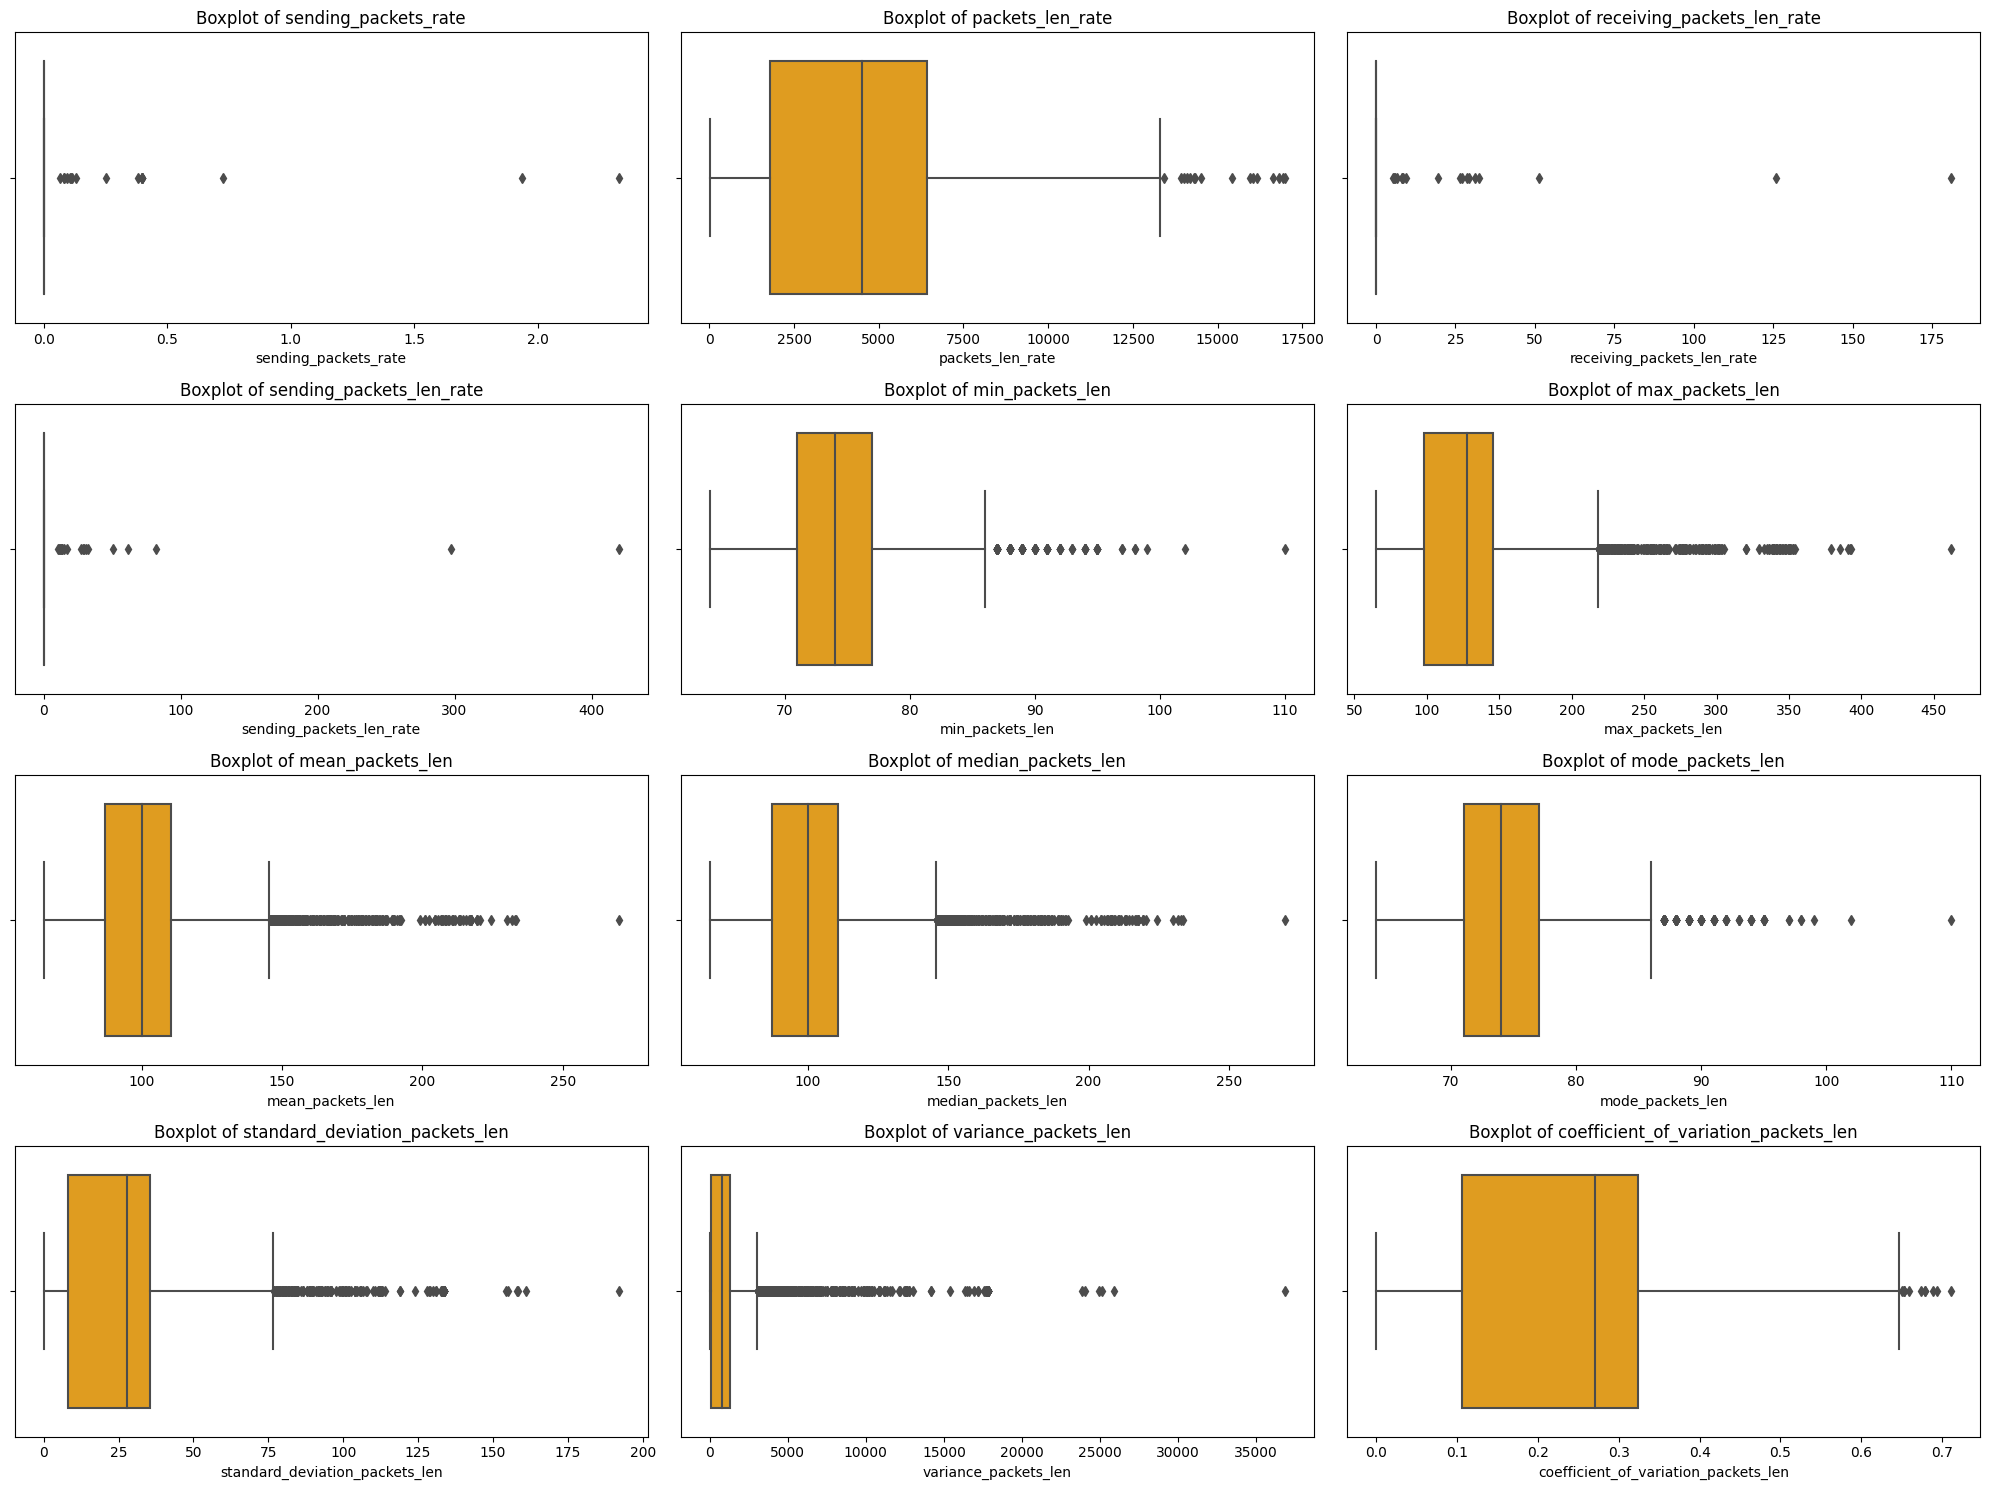

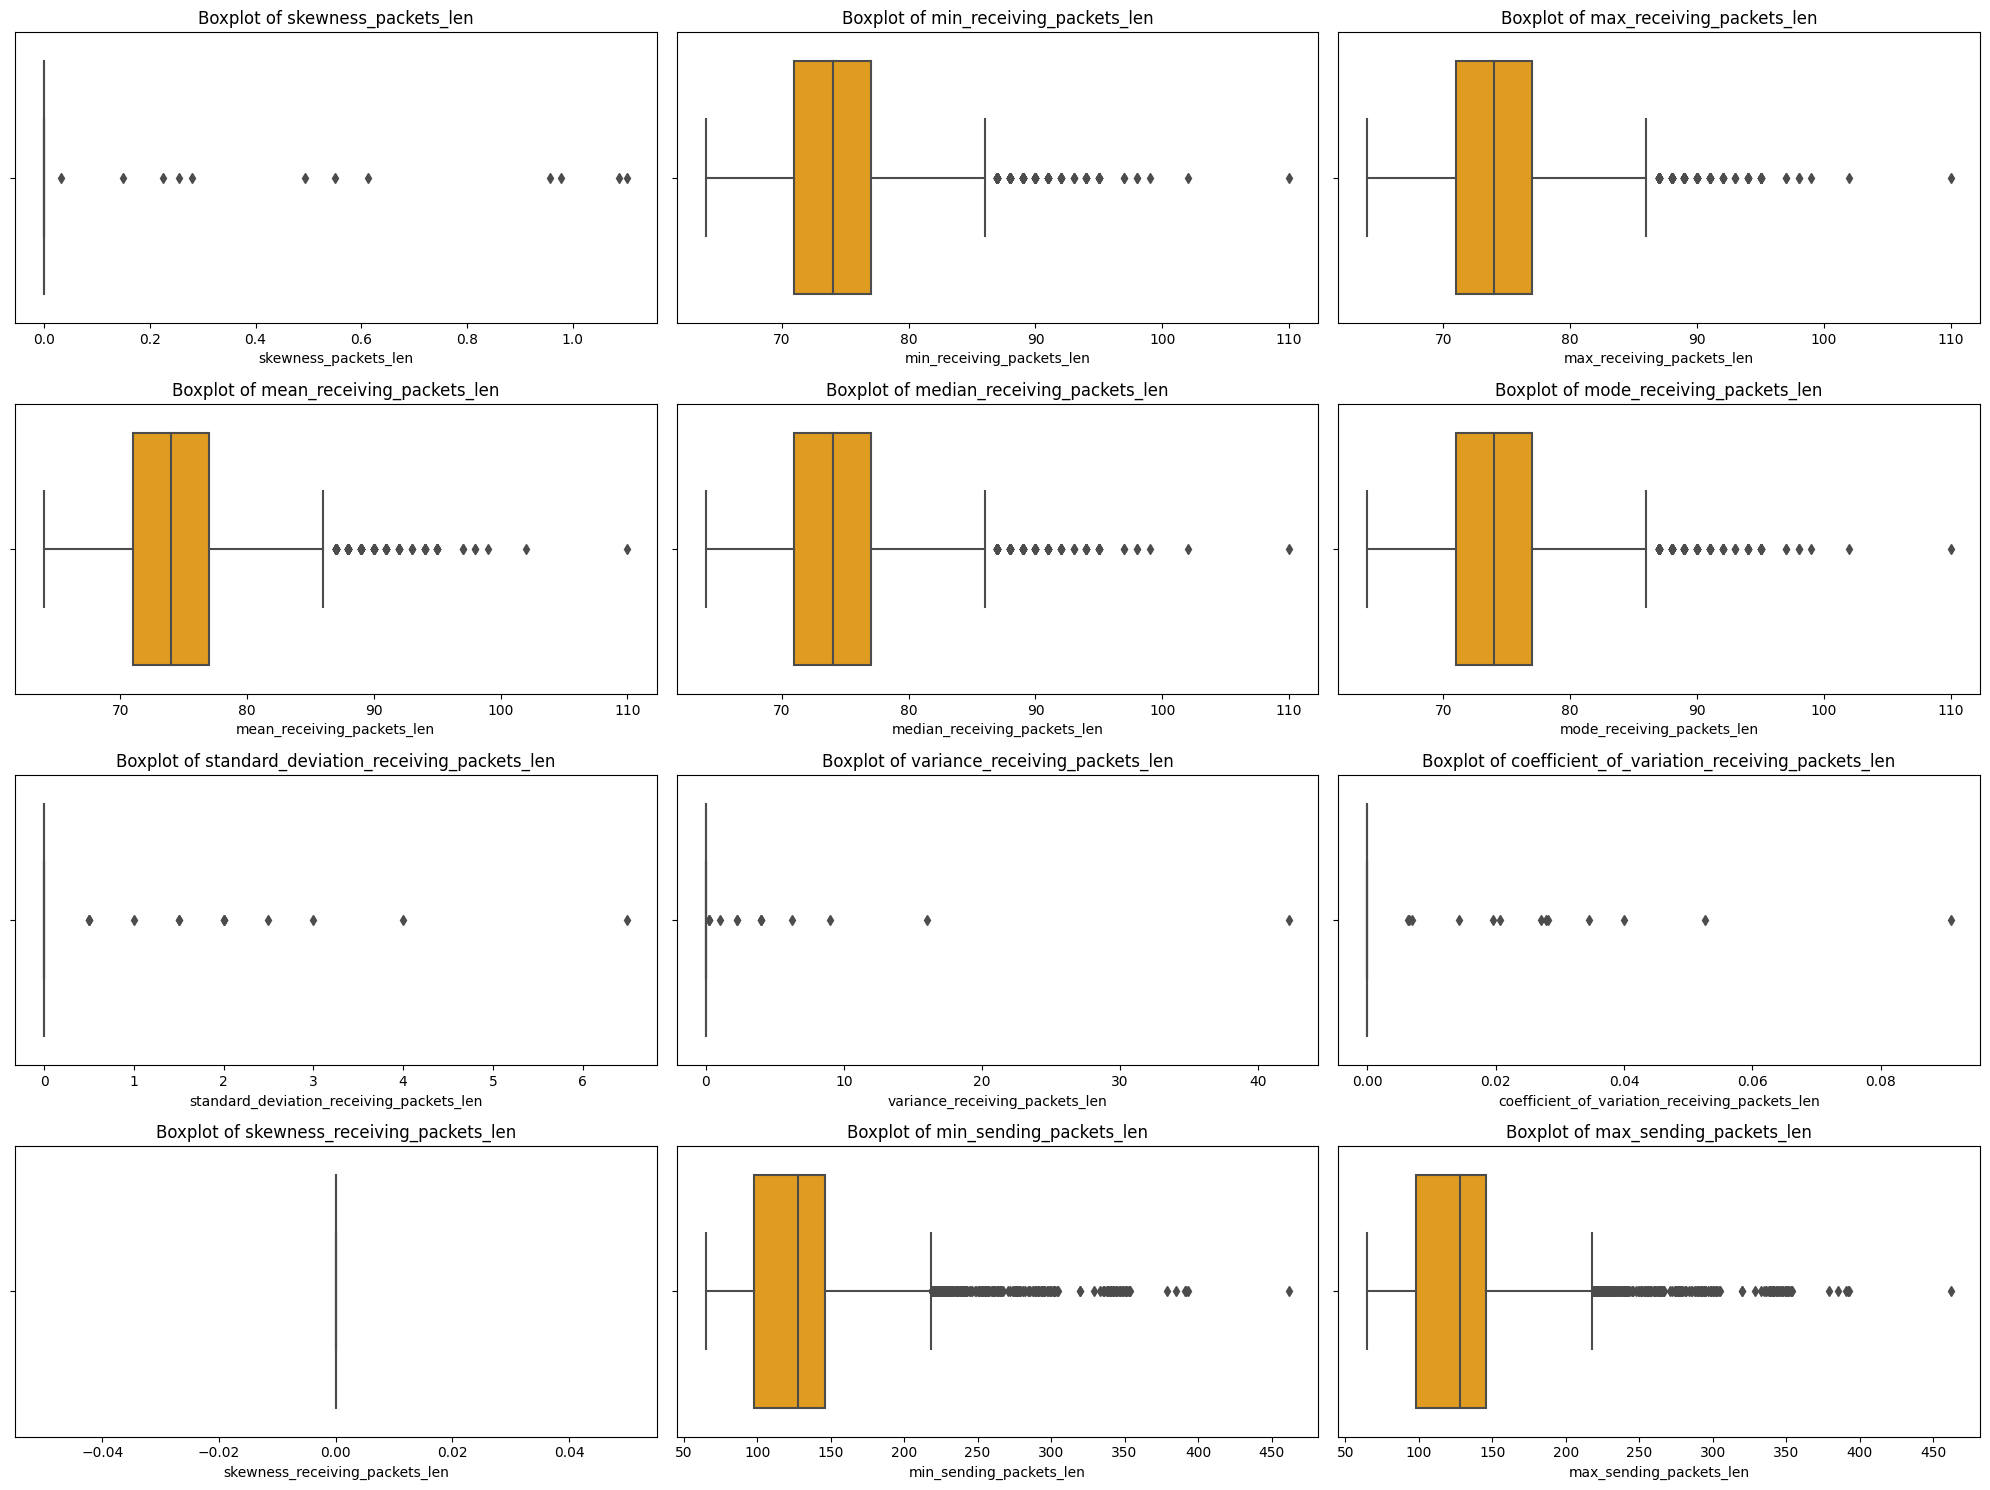

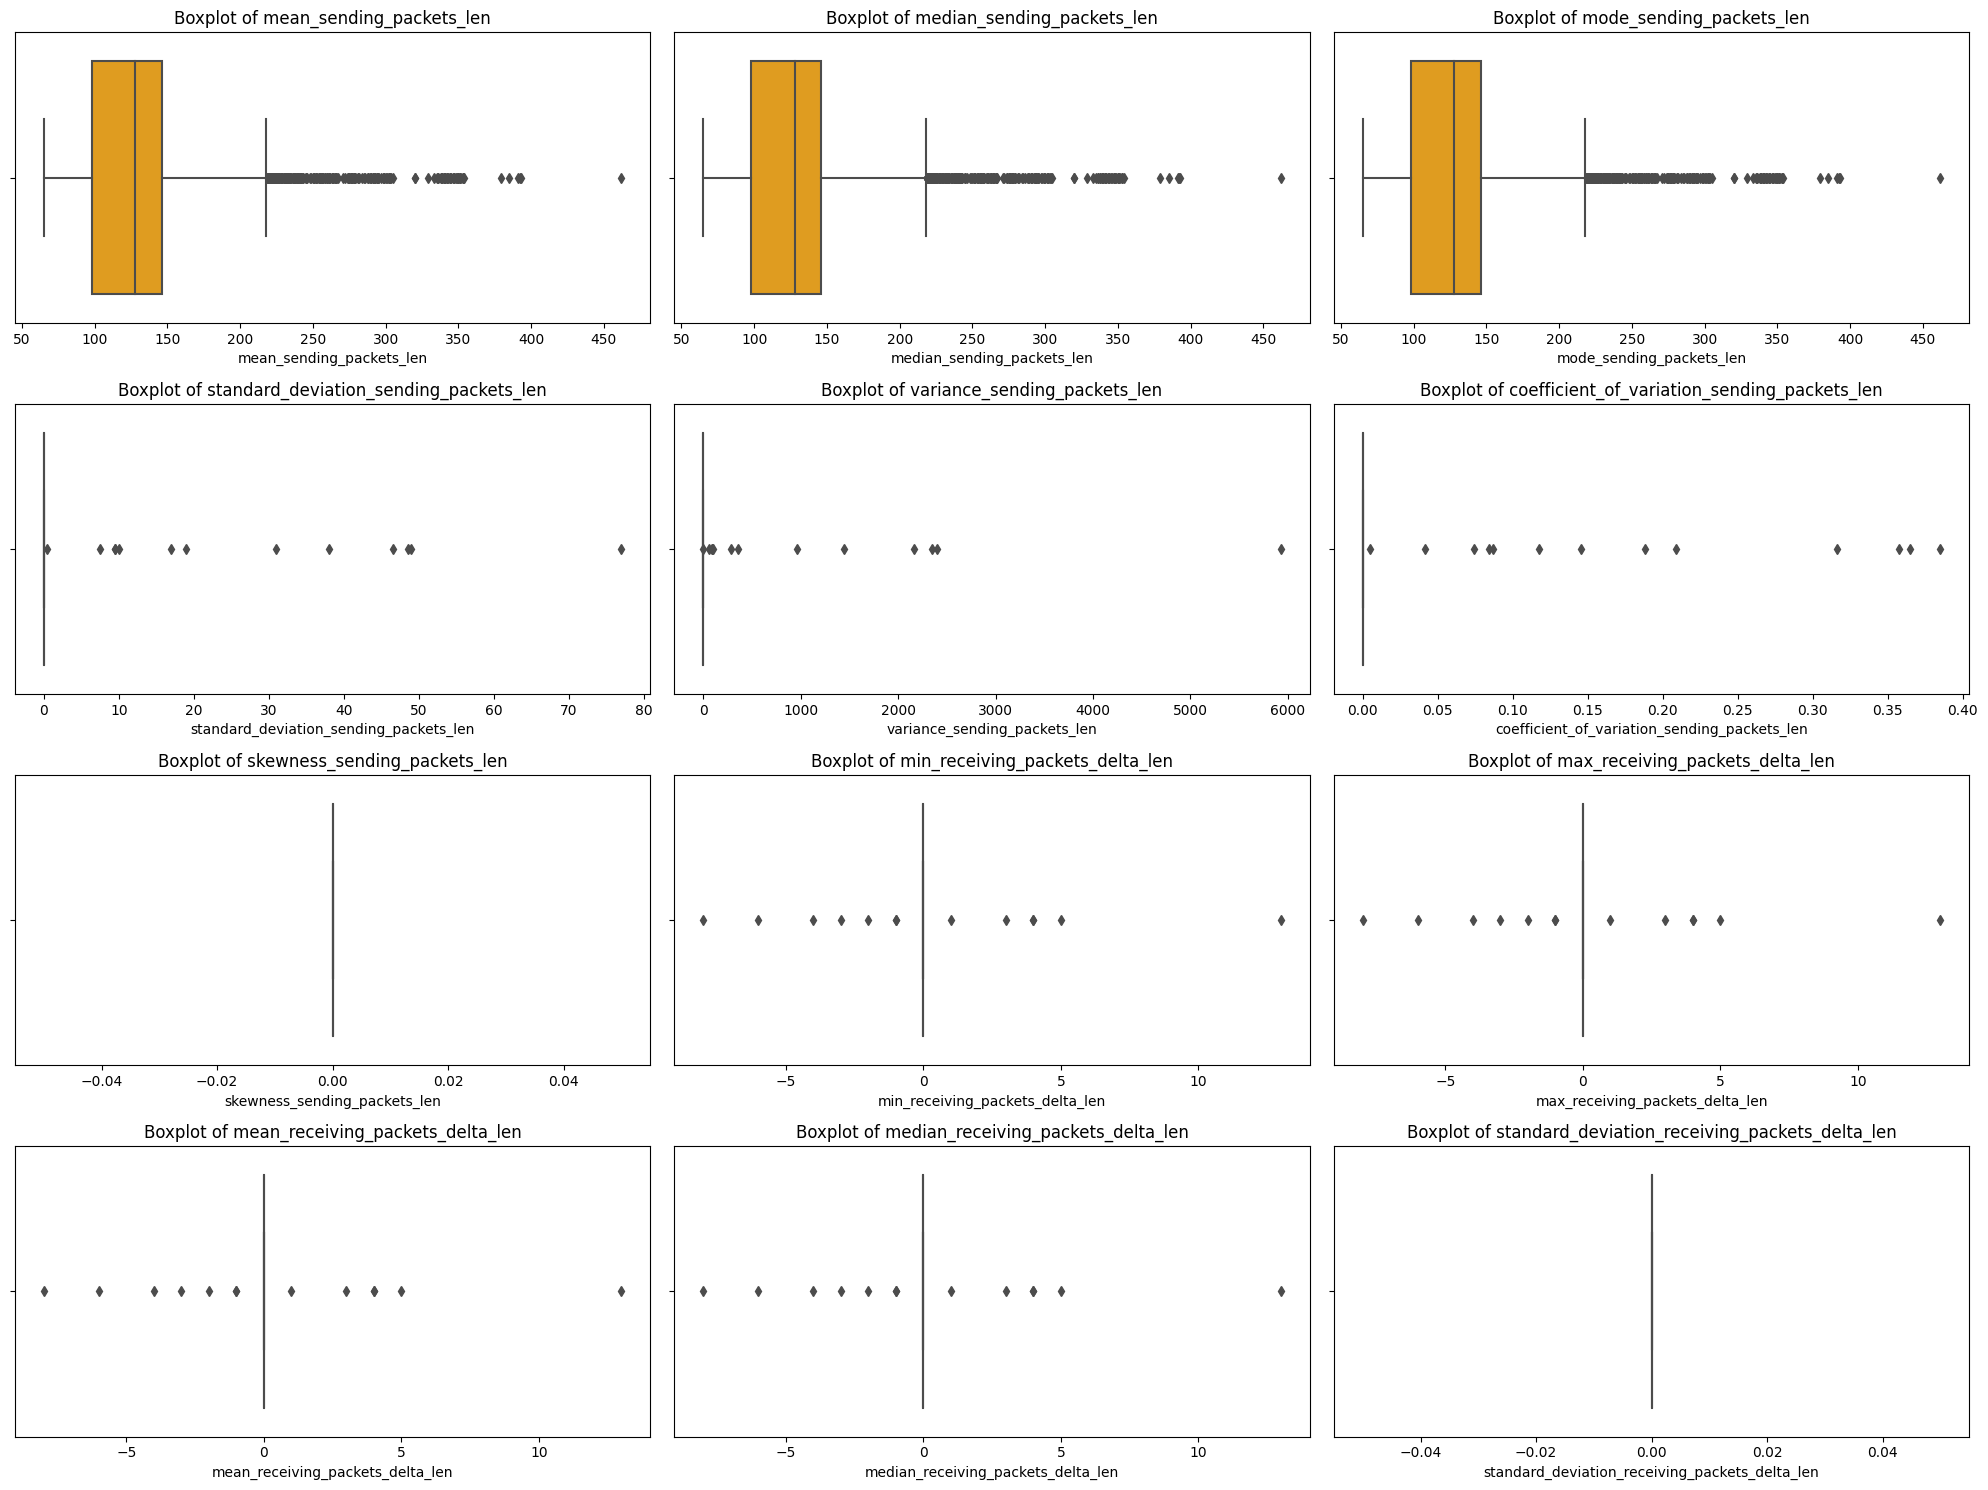

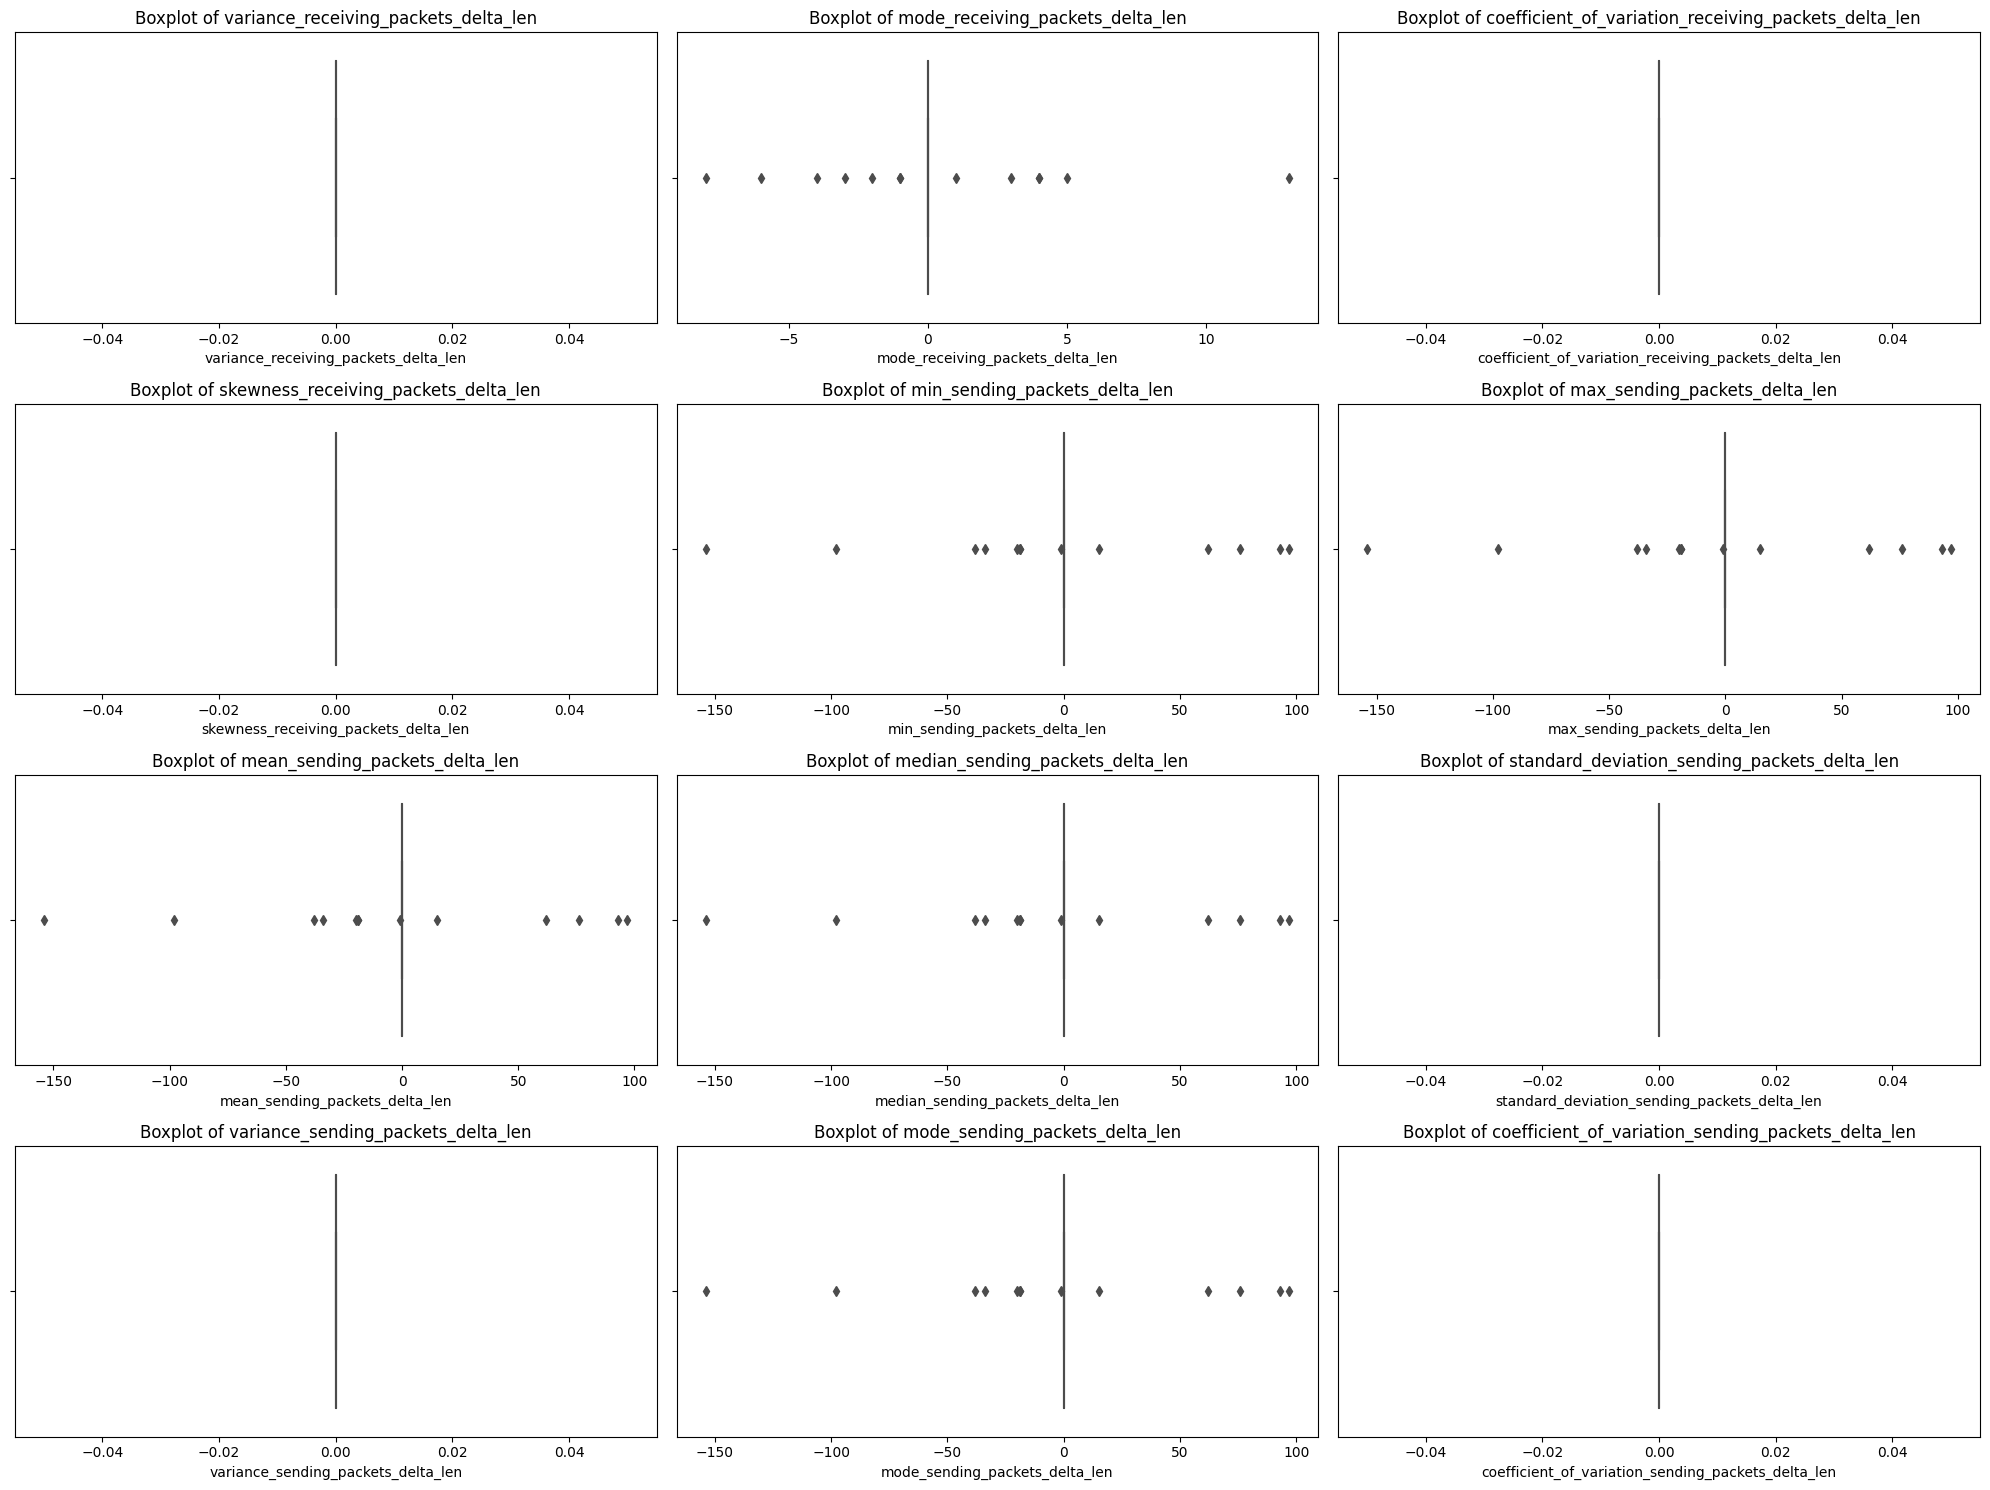

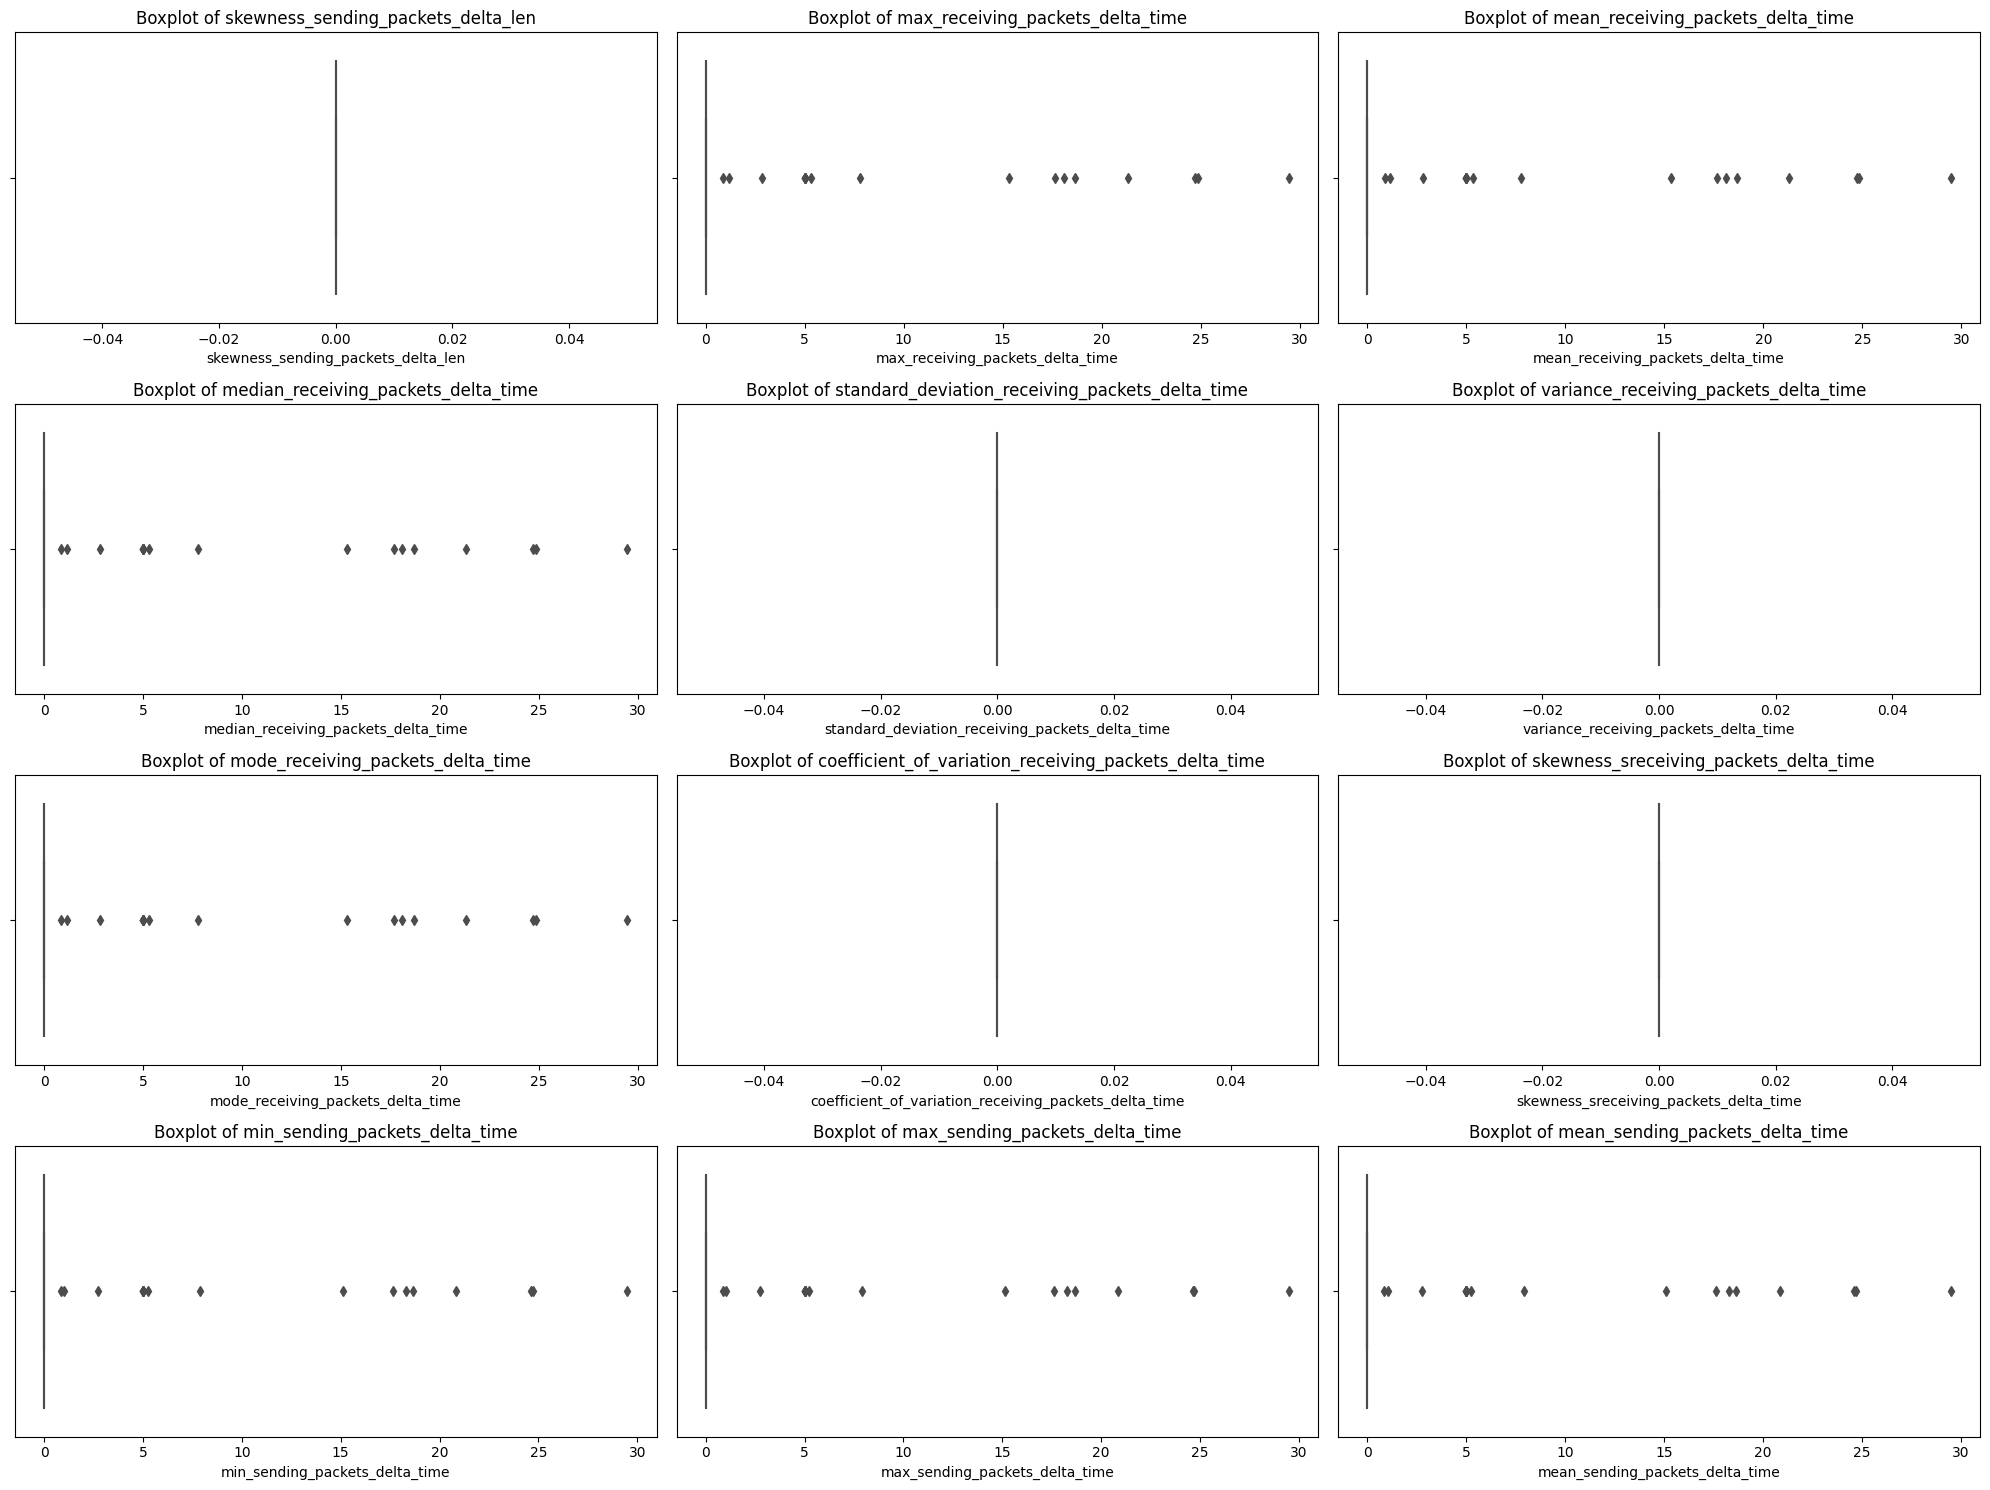

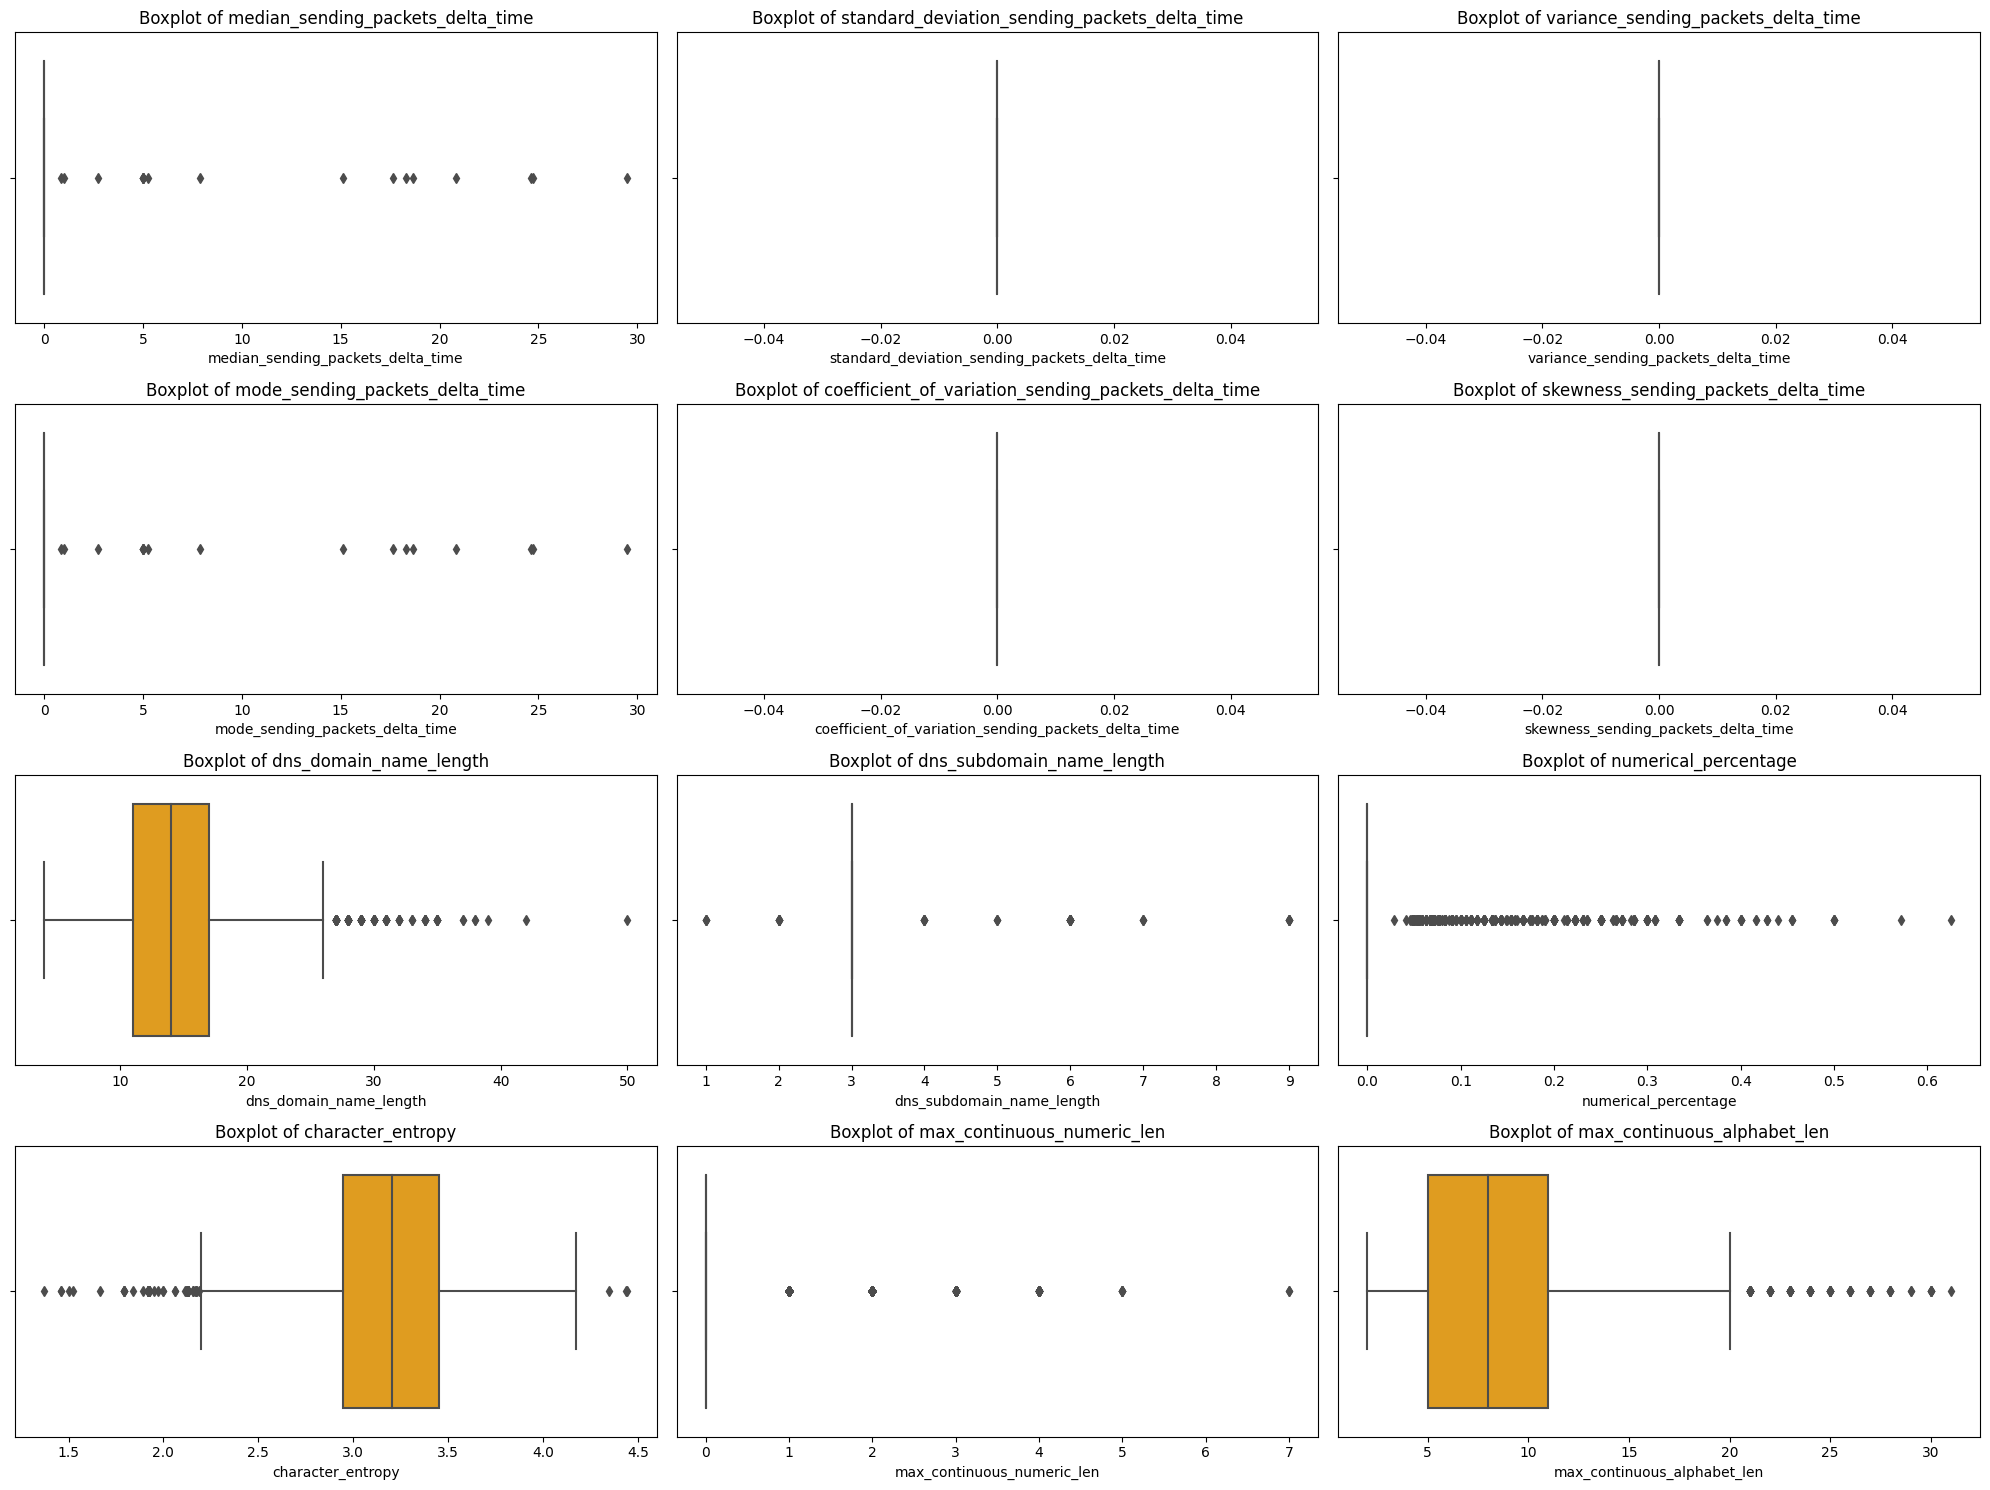

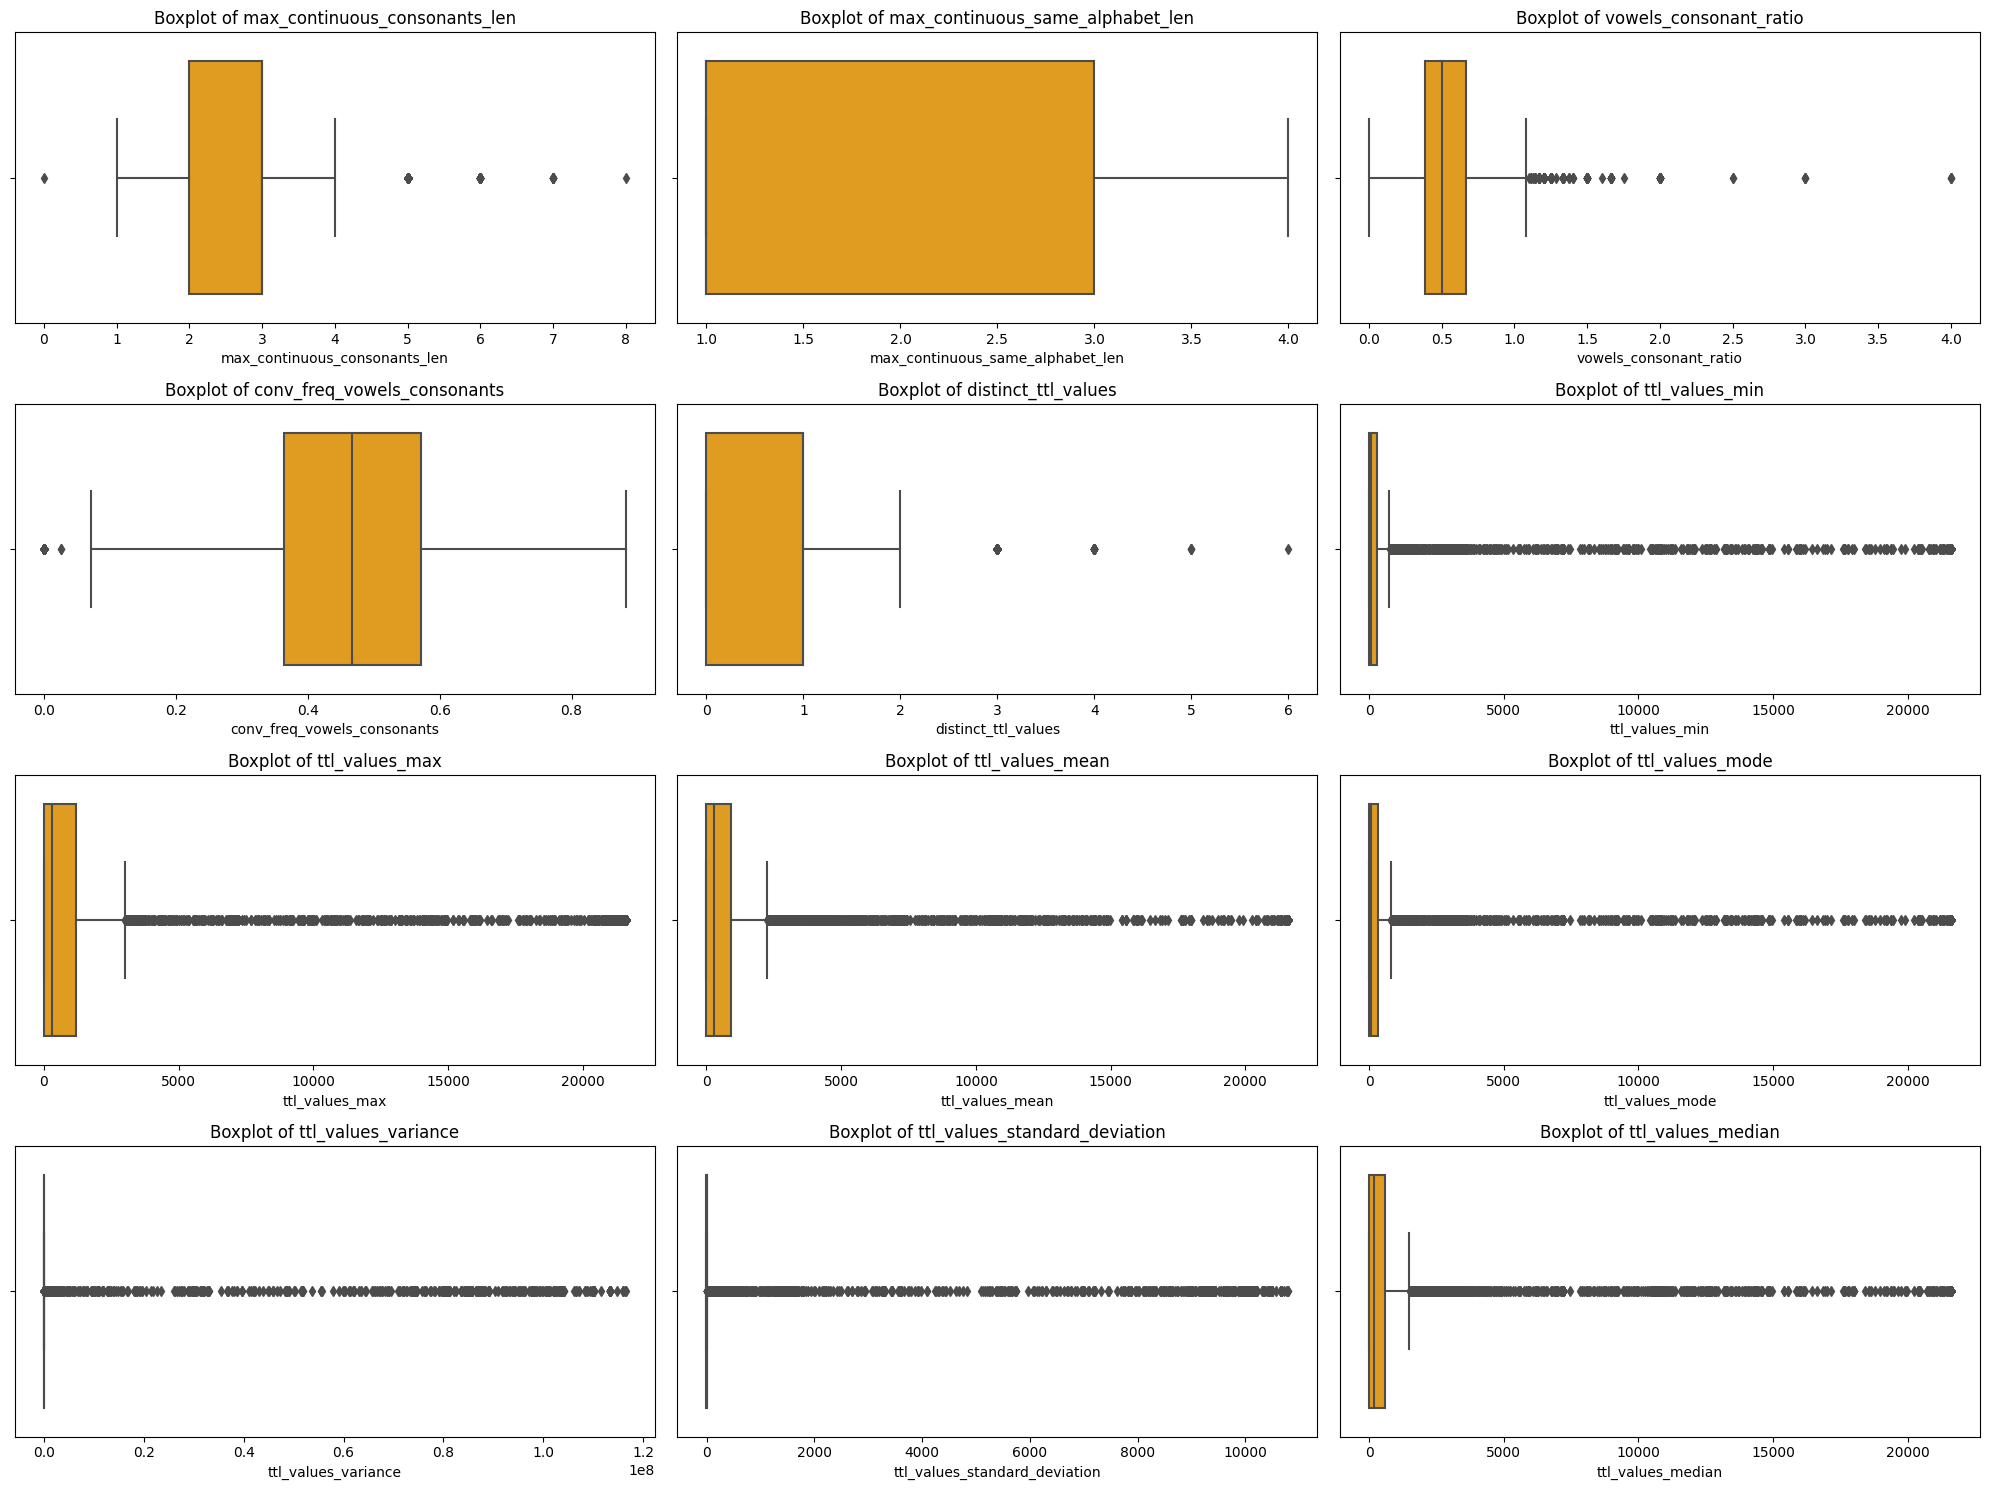

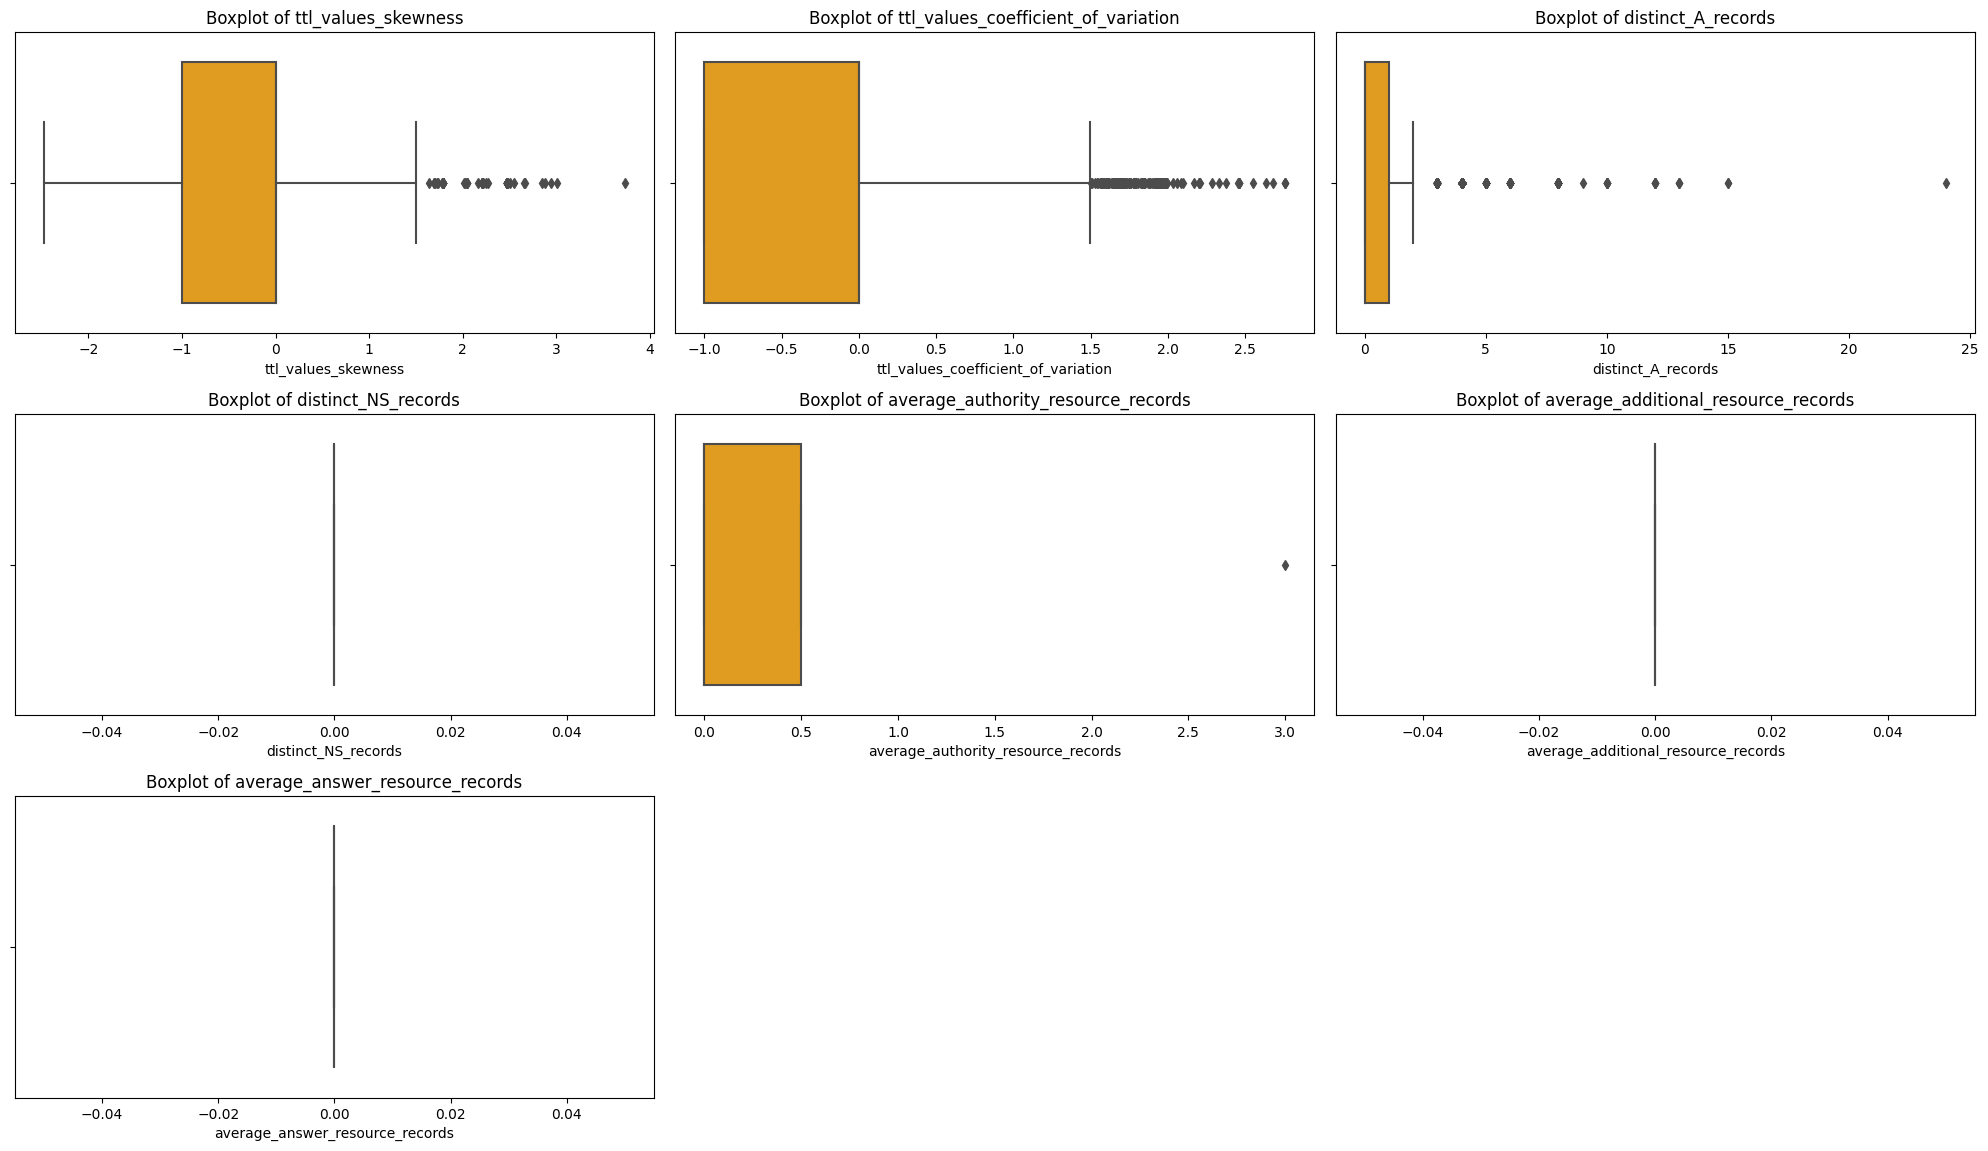

In [19]:
import math

# Define the batch size (number of plots per figure)
batch_size = 12

# Calculate the number of batches needed
num_batches = math.ceil(len(numerical_cols) / batch_size)

# Loop through each batch
for batch in range(num_batches):
    # Select the columns for the current batch
    start_index = batch * batch_size
    end_index = start_index + batch_size
    cols = numerical_cols[start_index:end_index]
    
    # Create a figure for the batch
    plt.figure(figsize=(20, 15))
    
    for i, col in enumerate(cols, 1):
        plt.subplot(4, 3, i)  # Adjust subplot grid based on batch size
        sns.boxplot(data=filtered_data, x=col, color='orange')
        plt.title(f'Boxplot of {col}')
        plt.xlabel(col)
    
    plt.tight_layout()
    plt.show()


# PREPROCESSING

## 1. Remove Irrelevant Columns

In [5]:
# List of columns to drop
columns_to_drop = [
    'Unnamed: 0', 'flow_id', 'timestamp', 'min_packets_len', 'max_packets_len', 'median_packets_len', 
    'mode_packets_len', 'min_receiving_packets_len', 'max_receiving_packets_len', 'median_receiving_packets_len', 
    'mode_receiving_packets_len', 'min_sending_packets_len', 'max_sending_packets_len', 
    'median_sending_packets_len', 'mode_sending_packets_len', 'min_receiving_packets_delta_len', 
    'max_receiving_packets_delta_len', 'median_receiving_packets_delta_len', 'min_sending_packets_delta_len',
    'max_sending_packets_delta_len', 'median_sending_packets_delta_len', 'mode_sending_packets_delta_len', 
    'max_receiving_packets_delta_time', 'median_receiving_packets_delta_time', 'mode_receiving_packets_delta_time', 
    'min_sending_packets_delta_time', 'max_sending_packets_delta_time', 'median_sending_packets_delta_time', 
    'mode_sending_packets_delta_time', 'ttl_values_min', 'ttl_values_max', 'ttl_values_mode', 'ttl_values_median'
]

# Drop the specified columns from the dataset
filtered_data.drop(columns=columns_to_drop, inplace=True)

# Display the shape of the dataset after dropping the columns
print("Dataset shape after dropping columns:", filtered_data.shape)


Dataset shape after dropping columns: (9687, 89)


<ipython-input-5-483e9c54d01f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.drop(columns=columns_to_drop, inplace=True)


In [6]:
# Check if all values in 'query_resource_record_type' are empty lists
if filtered_data['query_resource_record_type'].apply(lambda x: x == '[]').all():
    print("All values in 'query_resource_record_type' are empty lists.")
    # Drop the column if all values are empty lists
    filtered_data.drop(columns=['query_resource_record_type'], inplace=True)
    print("Column 'query_resource_record_type' dropped.")
else:
    print("Not all values in 'query_resource_record_type' are empty lists.")


All values in 'query_resource_record_type' are empty lists.
Column 'query_resource_record_type' dropped.


<ipython-input-6-b86da1343890>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.drop(columns=['query_resource_record_type'], inplace=True)


In [7]:
# Check if all values in 'query_resource_record_class' are empty lists ('[]')
empty_lists_check = filtered_data['query_resource_record_class'].apply(lambda x: x == '[]').all()

if empty_lists_check:
    print("All values in 'query_resource_record_class' are empty lists.")
else:
    print("Not all values in 'query_resource_record_class' are empty lists.")


All values in 'query_resource_record_class' are empty lists.


In [8]:
filtered_data.drop(columns=['query_resource_record_class'], inplace=True)

# Verify the column is dropped
print("Dataset after dropping 'query_resource_record_class':", filtered_data.shape)

Dataset after dropping 'query_resource_record_class': (9687, 87)


<ipython-input-8-af6fed00a090>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.drop(columns=['query_resource_record_class'], inplace=True)


In [9]:
columns_to_check = [
    'average_answer_resource_records', 'average_additional_resource_records', 'distinct_NS_records',
    'skewness_sending_packets_len', 'variance_sending_packets_len', 'standard_deviation_receiving_packets_len',
    'variance_receiving_packets_len', 'coefficient_of_variation_receiving_packets_len',
    'skewness_receiving_packets_len', 'variance_packets_len', 'coefficient_of_variation_packets_len',
    'skewness_packets_len', 'variance_sending_packets_len', 'coefficient_of_variation_sending_packets_len',
    'standard_deviation_receiving_packets_delta_len', 'variance_receiving_packets_delta_len',
    'coefficient_of_variation_receiving_packets_delta_len', 'skewness_receiving_packets_delta_len',
    'standard_deviation_sending_packets_delta_len', 'variance_sending_packets_delta_len',
    'coefficient_of_variation_sending_packets_delta_len', 'skewness_sending_packets_delta_len',
    'standard_deviation_receiving_packets_delta_time', 'variance_receiving_packets_delta_time',
    'coefficient_of_variation_receiving_packets_delta_time', 'skewness_sreceiving_packets_delta_time',
    'standard_deviation_sending_packets_delta_time', 'variance_sending_packets_delta_time',
    'coefficient_of_variation_sending_packets_delta_time', 'skewness_sending_packets_delta_time'
]

# Check unique values for the specified columns
for col in columns_to_check:
    print(f"Unique values in '{col}':")
    print(filtered_data[col].unique())
    print("--------")


Unique values in 'average_answer_resource_records':
[0.]
--------
Unique values in 'average_additional_resource_records':
[0.]
--------
Unique values in 'distinct_NS_records':
[0]
--------
Unique values in 'skewness_sending_packets_len':
[0.]
--------
Unique values in 'variance_sending_packets_len':
[0.00000e+00 5.62500e+01 2.50000e-01 2.35225e+03 9.61000e+02 2.40100e+03
 2.89000e+02 9.02500e+01 1.00000e+02 5.92900e+03 3.61000e+02 1.44400e+03
 2.16225e+03]
--------
Unique values in 'standard_deviation_receiving_packets_len':
[0.  0.5 2.5 3.  2.  1.5 4.  1.  6.5]
--------
Unique values in 'variance_receiving_packets_len':
[ 0.    0.25  6.25  9.    4.    2.25 16.    1.   42.25]
--------
Unique values in 'coefficient_of_variation_receiving_packets_len':
[0.         0.00628931 0.00645161 0.00689655 0.03448276 0.04
 0.02702703 0.02068966 0.02816901 0.05263158 0.02777778 0.01428571
 0.01960784 0.09090909]
--------
Unique values in 'skewness_receiving_packets_len':
[0.]
--------
Unique values

In [10]:
import pandas as pd

columns_to_check = [
    'average_answer_resource_records', 'average_additional_resource_records', 
    'distinct_NS_records', 'skewness_sending_packets_len', 'skewness_receiving_packets_len', 
    'standard_deviation_receiving_packets_delta_len', 'variance_receiving_packets_delta_len', 
    'skewness_receiving_packets_delta_len', 'standard_deviation_sending_packets_delta_len', 
    'variance_sending_packets_delta_len', 'skewness_sending_packets_delta_len', 
    'standard_deviation_receiving_packets_delta_time', 'variance_receiving_packets_delta_time', 
    'coefficient_of_variation_receiving_packets_delta_time', 'skewness_sreceiving_packets_delta_time', 
    'standard_deviation_sending_packets_delta_time', 'variance_sending_packets_delta_time', 
    'coefficient_of_variation_sending_packets_delta_time', 'skewness_sending_packets_delta_time'
]

# Loop through the specified columns and check if all unique values are 0
columns_to_drop = []

for column in columns_to_check:
    if filtered_data[column].nunique() == 1 and filtered_data[column].iloc[0] == 0:
        columns_to_drop.append(column)

# Drop the columns with only 0 values
filtered_data_cleaned = filtered_data.drop(columns=columns_to_drop)

# Display the cleaned DataFrame
print(f"Columns dropped: {columns_to_drop}")
print(filtered_data_cleaned.shape)


Columns dropped: ['average_answer_resource_records', 'average_additional_resource_records', 'distinct_NS_records', 'skewness_sending_packets_len', 'skewness_receiving_packets_len', 'standard_deviation_receiving_packets_delta_len', 'variance_receiving_packets_delta_len', 'skewness_receiving_packets_delta_len', 'standard_deviation_sending_packets_delta_len', 'variance_sending_packets_delta_len', 'skewness_sending_packets_delta_len', 'standard_deviation_receiving_packets_delta_time', 'variance_receiving_packets_delta_time', 'coefficient_of_variation_receiving_packets_delta_time', 'skewness_sreceiving_packets_delta_time', 'standard_deviation_sending_packets_delta_time', 'variance_sending_packets_delta_time', 'coefficient_of_variation_sending_packets_delta_time', 'skewness_sending_packets_delta_time']
(9687, 68)


In [11]:
general_info = [
    ["Number of Rows", filtered_data_cleaned.shape[0]],
    ["Number of Columns", filtered_data_cleaned.shape[1]],
    ["Total Missing Values", filtered_data_cleaned.isnull().sum().sum()]
]

# Tabulate and display
table = tabulate(general_info, headers=["Metric", "Value"], tablefmt="pretty")
print(table)

+----------------------+-------+
|        Metric        | Value |
+----------------------+-------+
|    Number of Rows    | 9687  |
|  Number of Columns   |  68   |
| Total Missing Values | 9419  |
+----------------------+-------+


## 2. Handling Missing Values

In [28]:
missing_data = filtered_data_cleaned.isna().sum()
for column, missing_count in missing_data.items():
    if missing_count > 0:
        print(f"Column: {column}, Missing Values: {missing_count}")

Column: coefficient_of_variation_receiving_packets_delta_len, Missing Values: 5
Column: coefficient_of_variation_sending_packets_delta_len, Missing Values: 5
Column: dns_subdomain_name_length, Missing Values: 9403
Column: ttl_values_coefficient_of_variation, Missing Values: 6


In [12]:
for col in ['coefficient_of_variation_receiving_packets_delta_len', 
            'coefficient_of_variation_sending_packets_delta_len', 
            'ttl_values_coefficient_of_variation']:
    filtered_data_cleaned[col].fillna(filtered_data[col].mean(), inplace=True)  

In [13]:
filtered_data_cleaned.drop(columns=['dns_subdomain_name_length'], inplace=True)

In [14]:
# Check for missing values in all columns
missing_values_after = filtered_data_cleaned.isnull().sum()

# Filter columns that still have missing values
missing_values_after = missing_values_after[missing_values_after > 0]

# If no missing values exist, print a message, else print the columns with missing values
if missing_values_after.empty:
    print("No missing values in the dataset.")
else:
    print("Columns with missing values:")
    print(missing_values_after)


No missing values in the dataset.


In [32]:
# Check if there are any NaN values in the scaled data
nan_check = filtered_data_cleaned.isna().sum()

# Filter columns where NaN count is greater than 0
nan_columns = nan_check[nan_check > 0]

# Print columns with NaN values
if len(nan_columns) > 0:
    print("Columns with NaN values:")
    print(nan_columns)
else:
    print("No NaN values in any column.")


No NaN values in any column.


In [18]:
print("after handling missing values and removing irrelevant columns: ")
filtered_data_cleaned.shape

after handling missing values and removing irrelevant columns: 


(9687, 67)

## 3. Remove Duplicate Records

In [19]:
duplicates_before = filtered_data_cleaned.duplicated().sum()
print(f"Number of duplicate rows before removal: {duplicates_before}")

Number of duplicate rows before removal: 0


In [ ]:
# INCASE OF ANY DUPLICATES-drop
filtered_data.drop_duplicates(inplace=True)
print("Dataset after removing duplicates:", filtered_data_cleaned.shape)

In [ ]:

print("Dataset after removing duplicates:", filtered_data_cleaned.shape)

## 4. Encoding Categorical Variables

In [15]:
# Print the names of categorical columns
categorical_columns = filtered_data_cleaned.select_dtypes(include=['object']).columns
print("Categorical Columns:")
print(categorical_columns)


Categorical Columns:
Index(['src_ip', 'dst_ip', 'protocol', 'handshake_duration', 'delta_start',
       'dns_domain_name', 'dns_top_level_domain', 'dns_second_level_domain',
       'uni_gram_domain_name', 'bi_gram_domain_name', 'tri_gram_domain_name',
       'character_distribution', 'ans_resource_record_type',
       'ans_resource_record_class', 'label'],
      dtype='object')


In [16]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

categorical_columns = [
    'src_ip', 'dst_ip', 'protocol', 'handshake_duration', 'delta_start',
    'dns_domain_name', 'dns_top_level_domain', 'dns_second_level_domain',
    'uni_gram_domain_name', 'bi_gram_domain_name', 'tri_gram_domain_name',
    'character_distribution', 'ans_resource_record_type',
    'ans_resource_record_class', 'label'
]

# Initialize a LabelEncoder
label_encoders = {}

# Apply label encoding to each categorical column
for column in categorical_columns:
    le = LabelEncoder()
    filtered_data_cleaned[column] = le.fit_transform(filtered_data_cleaned[column].astype(str))  # Convert to str if not already
    label_encoders[column] = le  # Save the encoder for later use if needed

# Check the transformed DataFrame
print(filtered_data_cleaned.head(2))


   src_ip  src_port  dst_ip  dst_port  protocol  duration  packets_numbers  \
0       0     58075       0        53         0  0.128087                2   
1       0     58075       0        53         0  0.043876                2   

   receiving_packets_numbers  sending_packets_numbers  handshake_duration  \
0                          1                        1                   0   
1                          1                        1                   0   

   ...  ttl_values_mean  ttl_values_variance  ttl_values_standard_deviation  \
0  ...             -1.0                 -1.0                           -1.0   
1  ...            599.0              90000.0                          300.0   

   ttl_values_skewness  ttl_values_coefficient_of_variation  \
0                 -1.0                            -1.000000   
1                  0.0                             0.500835   

   distinct_A_records  average_authority_resource_records  \
0                   0                       

In [37]:
# Print the names of categorical columns
categorical_columns = filtered_data_cleaned.select_dtypes(include=['object']).columns
print("Categorical Columns:")
print(categorical_columns)


Categorical Columns:
Index([], dtype='object')


In [17]:
filtered_data_cleaned.shape

(9687, 67)

In [39]:
print("AFTER PREPROCESSING-:")
general_info = [
    ["Number of Rows", filtered_data_cleaned.shape[0]],
    ["Number of Columns", filtered_data_cleaned.shape[1]],
    ["Total Missing Values", filtered_data_cleaned.isnull().sum().sum()]
]

# Tabulate and display
table = tabulate(general_info, headers=["Metric", "Value"], tablefmt="pretty")
print(table)

AFTER PREPROCESSING-:
+----------------------+-------+
|        Metric        | Value |
+----------------------+-------+
|    Number of Rows    | 9687  |
|  Number of Columns   |  67   |
| Total Missing Values |   0   |
+----------------------+-------+


## 5.Feature Selection


In [18]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Separate features and target
X = filtered_data_cleaned.drop('label', axis=1)
y = filtered_data_cleaned['label']

# Train a Random Forest for feature importance
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)

# Extract feature importance
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(feature_importances)

# Optional: Select top features (e.g., top 10)
top_features = feature_importances.head(10)['Feature'].tolist()
X = X[top_features]  # Reduce dataset to important features


Feature Importances:
                                              Feature  Importance
1                                            src_port    0.538458
48                             character_distribution    0.188731
49                                  character_entropy    0.027791
12                                    receiving_bytes    0.024601
25                         mean_receiving_packets_len    0.023753
..                                                ...         ...
34                   mode_receiving_packets_delta_len    0.000000
35  coefficient_of_variation_receiving_packets_del...    0.000000
36                     mean_sending_packets_delta_len    0.000000
37  coefficient_of_variation_sending_packets_delta...    0.000000
33                   mean_receiving_packets_delta_len    0.000000

[66 rows x 2 columns]


In [19]:
print("AFTER Feature Selection-:")
general_info = [
    ["Number of Rows", X.shape[0]],
    ["Number of Columns", X.shape[1]],
    ["Total Missing Values", X.isnull().sum().sum()]
]

# Tabulate and display
table = tabulate(general_info, headers=["Metric", "Value"], tablefmt="pretty")
print(table)

AFTER Feature Selection-:
+----------------------+-------+
|        Metric        | Value |
+----------------------+-------+
|    Number of Rows    | 9687  |
|  Number of Columns   |  10   |
| Total Missing Values |   0   |
+----------------------+-------+


In [42]:
print("Shape of X after removing dropped features:", X.shape)
print("Columns in X after processing:", X.columns.tolist())


Shape of X after removing dropped features: (9687, 10)
Columns in X after processing: ['src_port', 'character_distribution', 'character_entropy', 'receiving_bytes', 'mean_receiving_packets_len', 'dns_domain_name_length', 'max_continuous_alphabet_len', 'tri_gram_domain_name', 'uni_gram_domain_name', 'dns_domain_name']


## 6.Balancing DataSet

In [20]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Assuming you have your features X and target y already defined

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE with a sampling strategy of 0.9 (90% of majority class size)
smote = SMOTE(sampling_strategy=0.9, random_state=42)

# Resample the training data
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check the shape of the resampled data
print(f"Original training data shape: {X_train.shape}, {y_train.value_counts()}")
print(f"Resampled training data shape: {X_train_smote.shape}, {y_train_smote.value_counts()}")


Original training data shape: (7749, 10), label
0    7647
1     102
Name: count, dtype: int64
Resampled training data shape: (14529, 10), label
0    7647
1    6882
Name: count, dtype: int64


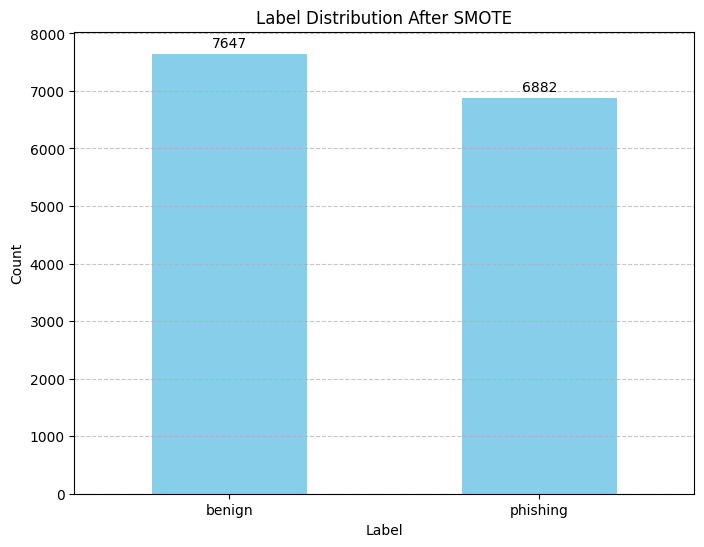

In [26]:
import matplotlib.pyplot as plt
import pandas as pd

# Map numerical labels to descriptive names
label_mapping = {0: 'benign', 1: 'phishing'}
y_train_smote_mapped = pd.Series(y_train_smote).map(label_mapping)

# Plot the label distribution
plt.figure(figsize=(8, 6))
counts = y_train_smote_mapped.value_counts()
ax = counts.plot(kind='bar', color='skyblue')

# Annotate bars with counts
for i, count in enumerate(counts):
    ax.text(i, count + 50, str(count), ha='center', va='bottom', fontsize=10)

plt.title('Label Distribution After SMOTE')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [27]:
print("AFTER BALANCING DATSET-:")
general_info = [
    ["Number of Rows", X_train_smote.shape[0]],
    ["Number of Columns", X_train_smote.shape[1]],
    ["Original Training Data Shape", f"{X_train.shape}, {y_train.value_counts().to_dict()}"],
    ["Resampled Training Data Shape", f"{X_train_smote.shape}, {y_train_smote.value_counts().to_dict()}"]
]

# Tabulate and display
table = tabulate(general_info, headers=["Metric", "Value"], tablefmt="pretty")
print(table)

AFTER BALANCING DATSET-:
+-------------------------------+---------------------------------+
|            Metric             |              Value              |
+-------------------------------+---------------------------------+
|        Number of Rows         |              14529              |
|       Number of Columns       |               10                |
| Original Training Data Shape  |  (7749, 10), {0: 7647, 1: 102}  |
| Resampled Training Data Shape | (14529, 10), {0: 7647, 1: 6882} |
+-------------------------------+---------------------------------+


# Correlation

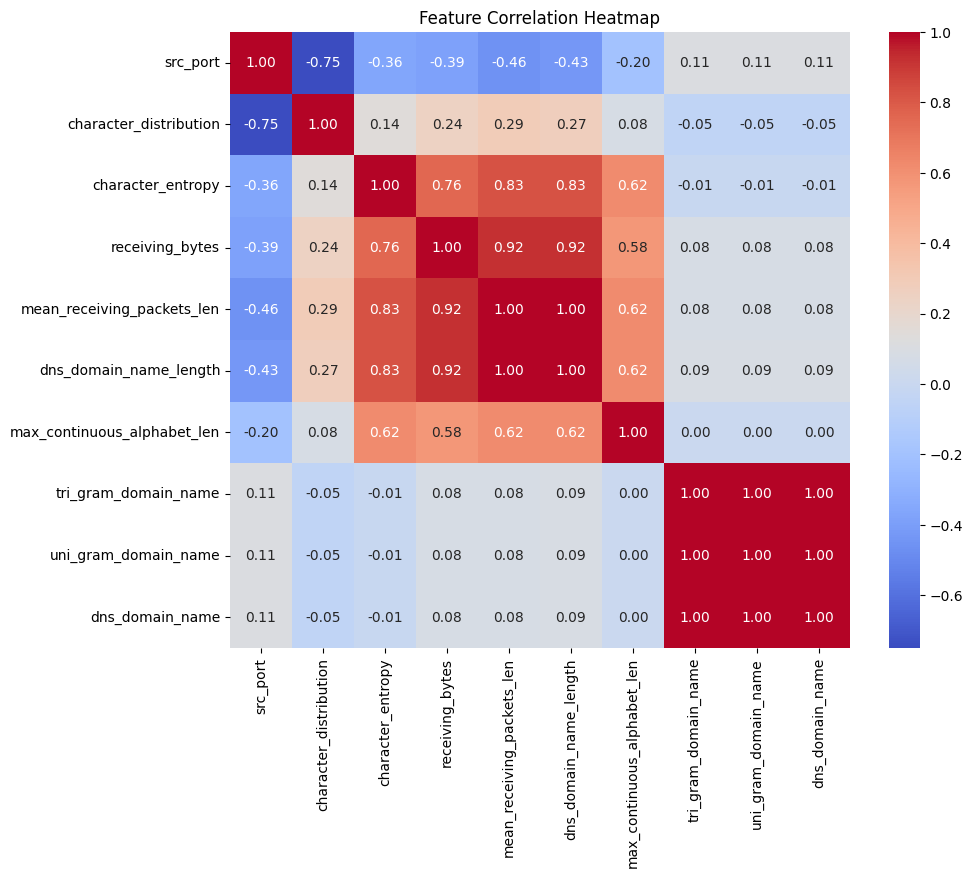

In [45]:
# Calculate correlation matrix of the resampled training data
correlation_matrix = pd.DataFrame(X_train_smote, columns=X_train.columns).corr()


# Visualize correlations using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

# Deep Learning

## TABNET

In [21]:
!pip install pytorch-tabnet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.2 MB/s eta 0:00:00


In [38]:
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import classification_report, accuracy_score

# Convert pandas DataFrame to NumPy arrays
X_train_smote_np = X_train_smote.values
y_train_smote_np = y_train_smote.values
X_test_np = X_test.values
y_test_np = y_test.values

# Initialize the TabNet classifier
clf = TabNetClassifier()

# Train the model with the SMOTE-balanced dataset
clf.fit(
    X_train_smote_np, y_train_smote_np,
    eval_set=[(X_test_np, y_test_np)],
    eval_metric=['accuracy'],
    max_epochs=200,
    patience=20,
    batch_size=256,
    virtual_batch_size=128
)

# Predict on the test set
preds = clf.predict(X_test_np)

# Evaluate the model
print("Test Accuracy:", accuracy_score(y_test_np, preds))
print("Classification Report:\n", classification_report(y_test_np, preds))


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.11235 | val_0_accuracy: 0.90815 |  0:00:01s
epoch 1  | loss: 0.00051 | val_0_accuracy: 0.98762 |  0:00:02s
epoch 2  | loss: 0.00135 | val_0_accuracy: 0.99071 |  0:00:04s
epoch 3  | loss: 0.00041 | val_0_accuracy: 0.99329 |  0:00:05s
epoch 4  | loss: 0.00032 | val_0_accuracy: 0.99897 |  0:00:07s
epoch 5  | loss: 0.00029 | val_0_accuracy: 0.99948 |  0:00:08s
epoch 6  | loss: 0.00027 | val_0_accuracy: 0.99948 |  0:00:10s
epoch 7  | loss: 0.00024 | val_0_accuracy: 0.99948 |  0:00:11s
epoch 8  | loss: 0.00024 | val_0_accuracy: 0.99948 |  0:00:13s
epoch 9  | loss: 0.00022 | val_0_accuracy: 0.99948 |  0:00:14s
epoch 10 | loss: 0.0002  | val_0_accuracy: 0.99948 |  0:00:16s
epoch 11 | loss: 0.00019 | val_0_accuracy: 0.99948 |  0:00:17s
epoch 12 | loss: 0.00018 | val_0_accuracy: 0.99948 |  0:00:19s
epoch 13 | loss: 0.00016 | val_0_accuracy: 0.99948 |  0:00:20s
epoch 14 | loss: 0.00015 | val_0_accuracy: 0.99948 |  0:00:22s
epoch 15 | loss: 0.00015 | val_0_accuracy: 0.99948 |  0

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Test Accuracy: 0.999484004127967
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1920
           1       1.00      0.94      0.97        18

    accuracy                           1.00      1938
   macro avg       1.00      0.97      0.99      1938
weighted avg       1.00      1.00      1.00      1938



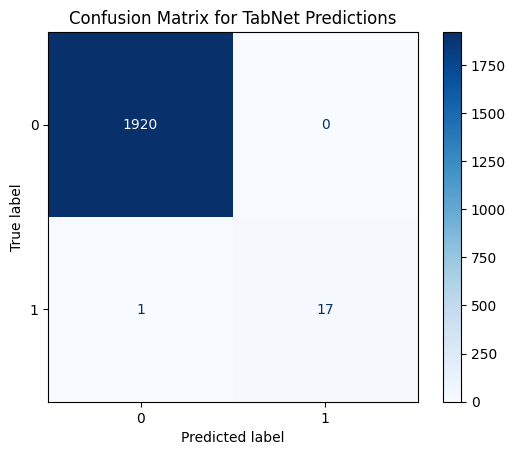

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming y_test_np and preds are already defined from your previous steps

# Step 1: Generate the confusion matrix
cm = confusion_matrix(y_test_np, preds)

# Step 2: Create a display for the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)

# Step 3: Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for TabNet Predictions')
plt.show()


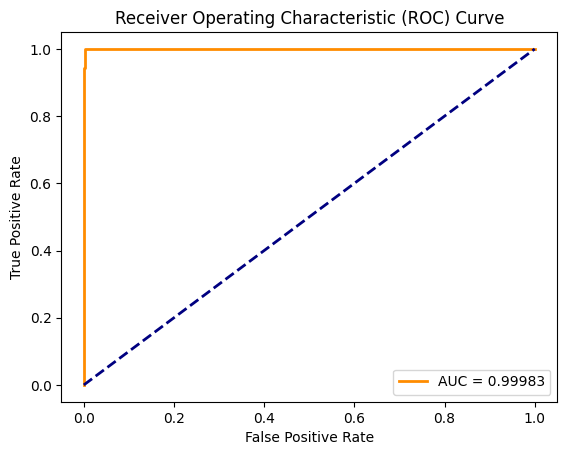

In [40]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Predict probabilities for the positive class
y_pred_proba = clf.predict_proba(X_test_np)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test_np, y_pred_proba)
roc_auc = roc_auc_score(y_test_np, y_pred_proba)

# Plot the AUC-ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.5f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()



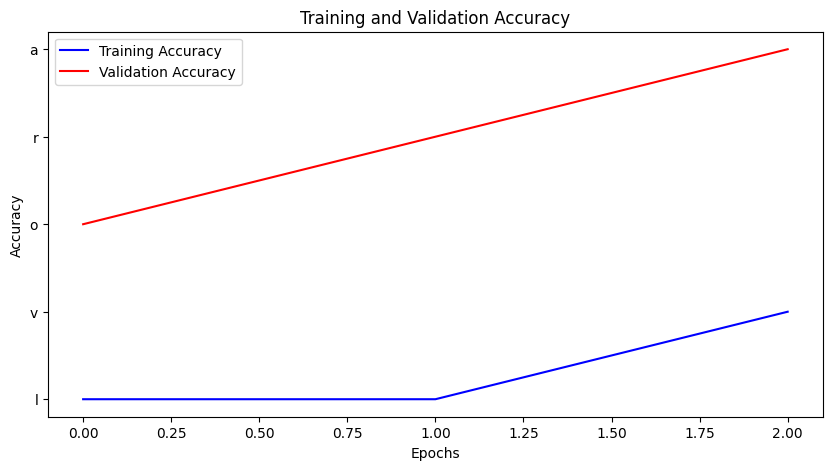

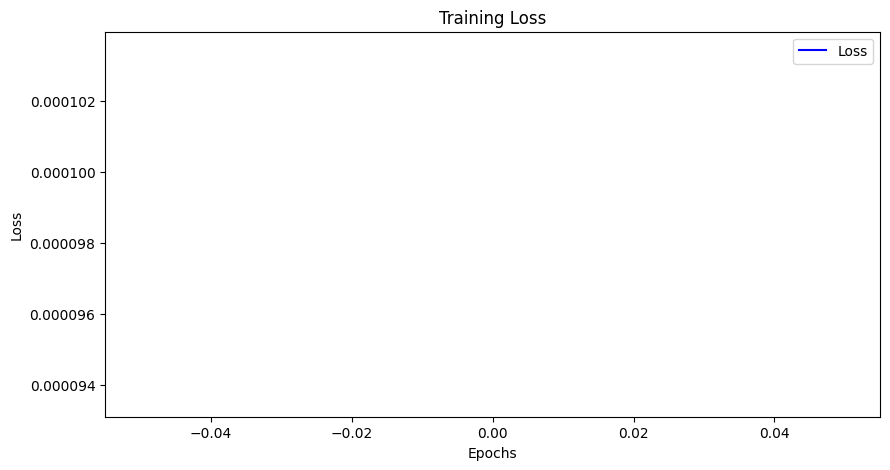

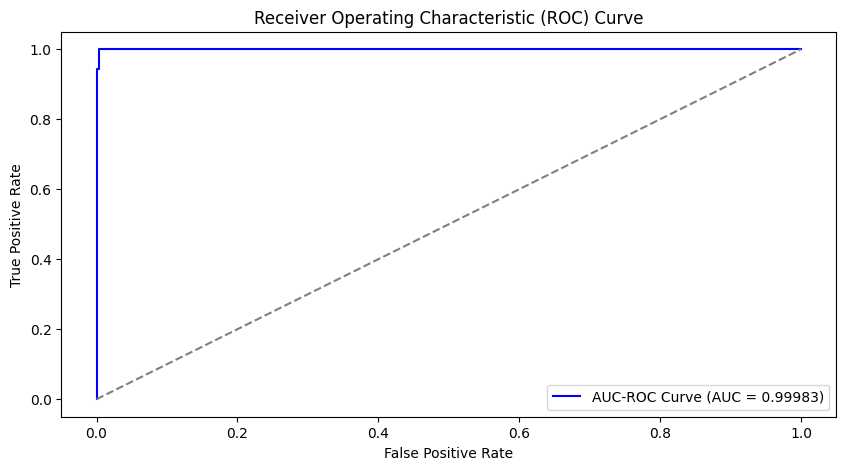

AUC-ROC Score: 0.9998263888888889


In [41]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

# Print the available keys in the history
#print("Available keys in history:", clf.history.keys())
# Print the available keys or attributes in history to inspect its structure
#print("Available attributes in history:", dir(clf.history))


import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

# Extract epoch loss and metrics
epoch_loss = clf.history.epoch_loss
epoch_metrics = clf.history.epoch_metrics

# Assuming `epoch_metrics` contains tuples or lists with accuracy and other metrics,
# you can extract accuracy from these metrics.

train_accuracy = [metric[0] for metric in epoch_metrics]  # Assuming first metric is accuracy
valid_accuracy = [metric[1] for metric in epoch_metrics]  # Assuming second metric is validation accuracy

# Plot accuracy curves
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy, label='Training Accuracy', color='blue')
plt.plot(valid_accuracy, label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot loss curves
plt.figure(figsize=(10, 5))
plt.plot(epoch_loss, label='Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

# Compute and plot AUC-ROC curve
y_proba = clf.predict_proba(X_test_np)[:, 1]  # Probability for the positive class
roc_auc = roc_auc_score(y_test_np, y_proba)
fpr, tpr, thresholds = roc_curve(y_test_np, y_proba)

plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, color='blue', label=f'AUC-ROC Curve (AUC = {roc_auc:.5f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

print("AUC-ROC Score:", roc_auc)

